In [230]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [231]:
# Following: https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from sklearn import metrics
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import numpy as np
import shap
import os
import pickle

from utils import plot_ss_curve
from rtog_helper import RTOG, rtog_from_study_number

# Class to load image quilts, and convert them to Catboost-ready format
from rtog_image_helper import ImageLoader
loader = ImageLoader()

def printc(df):
    """Helper function. Prints all the columns of a pandas dataframe."""
    prev = pd.options.display.max_columns
    prev_r = pd.options.display.max_rows
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 20
    display(df)
    pd.options.display.max_columns = prev
    pd.options.display.max_rows = prev_r
    
load_from_cache = True

if load_from_cache:
    print("Loading rtogs from cache")
    with open("./.cache/studies.pkl", "rb") as f:
        studies = pickle.load(f)
    with open("./.cache/loader.pkl", "rb") as f:
        loader = pickle.load(f)

else:

    #Load NRG Data
    print("Loading rtogs from filesystem")
    studies = {}

    # Select SSL Model
    prefix = "/export/medical_ai/ucsf/ssl_rtog/moco/"
    features_dir = prefix + "model_R50_b=256_lr=0.03_pg4plus/features/RTOG-{}_quilts/"
    features_dir = prefix + "model_R50_b=256_lr=0.03_pg4plus_fulldata/features/RTOG-{}_quilts/"
    features_dir = prefix + "model_R50_b=256_lr=0.03_pg4plus_fulldata/features/master_list_quilts/RTOG-{}_quilts/"
    # features_dir = prefix + "model_R50_b=256_lr=0.03_pg4plus_imagenet_pretrained/features/RTOG_{}_quilts/"
    # features_dir = prefix + "model_R50_b=256_lr=0.03_pg4plus_imagenet_pretrained-800/features/RTOG-{}_quilts/"
    # features_dir = prefix + "model_R50_b=256_lr=0.03_pg4plus_imagenet_pretrained_nucleic/features/RTOG-{}_quilts"

    # Load Data
    cases = []
    quilts = []
    for sn in ['9202', '9408', '9413', '0126', '9910']:
        studies[sn] = rtog_from_study_number(sn, standardize=True)
        feat_dir = features_dir.format(sn)

        # Add the feature quilts if available
        if os.path.exists(feat_dir):
            feature_quilt_paths = sorted([os.path.join(feat_dir,i) for i in os.listdir(feat_dir) if '.pkl' in i])
            cn_deids = np.array([int(i.split("/")[-1].split('_')[0]) for i in feature_quilt_paths])
            cases.append(cn_deids)
            quilts.append(feature_quilt_paths)
#             print("Loaded {} feature-quilts\n{}\n".format(len(feature_quilt_paths), feat_dir))
            print("Loaded {} unique quilts from {} unique cases\n{}\n".format(
                len(np.unique(feature_quilt_paths)), len(np.unique(cn_deids)), feat_dir)
            )

            studies[sn].df['featquilt'] = ''
            not_in_RTOG_varlistings = []
            excess = []
            unique_cases = studies[sn].df['cn_deidentified'].unique()
            for id, path in zip(cn_deids, feature_quilt_paths):
                if id not in unique_cases:
                    not_in_RTOG_varlistings.append((id, path))
                if studies[sn].df.loc[studies[sn].df['cn_deidentified'] == id, 'featquilt'].values:
                    excess.append((id, path))
                studies[sn].df.loc[studies[sn].df['cn_deidentified'] == id, 'featquilt'] = path
            print("Seeing {} unique featquilts".format(studies[sn].df[['featquilt']].nunique()))
            print("not_in_RTOG_varlistings: {}".format(len(not_in_RTOG_varlistings)))
            print("Excess: {}".format(len(excess)))
            print()
    cases = np.concatenate(cases)
    quilts = [qq for q in quilts for qq in q]
                
for sn in ['9202', '9408', '9413', '9910', '0126']:
    print(sn, studies[sn].df.shape, studies[sn].df['rx'].unique())

Loading rtogs from cache
9202 (1520, 57) [1. 2.]
9408 (1974, 73) [1. 0.]
9413 (1270, 75) [1]
9910 (1489, 64) [3. 1.]
0126 (1499, 69) [0.]


In [232]:
# not_in_RTOG_varlistings

### Delete these cells - they bug check Sandy's master lists vs ours
 

In [233]:
# import pandas as pd
# import os

# # Understand Sandy's files
# sandy = {
#     '9910' : pd.read_excel("./sandy_master_excel_files/9910-Master-deid-SF-8.12.21QA.xlsx").rename(columns=str.lower),
#     '9202' : pd.read_excel("./sandy_master_excel_files/9202-Master-Deid-SF-Upload-8.12.2021.xlsx").rename(columns=str.lower),
#     '9408' : pd.read_excel("./sandy_master_excel_files/9408-Master-Deid-SF-8.12.21.xlsx").rename(columns=str.lower),
#     '9413' : pd.read_excel("./sandy_master_excel_files/9413-Master-De-id List_SF-8.12.2021.xlsx").rename(columns=str.lower),
#     '0126' : pd.read_excel("./sandy_master_excel_files/0126 Master Export-De-id-SF-8.12.2021.xlsx").rename(columns=str.lower),
# }
# sandy = {key : val.rename(columns={'cn_deid' : 'cn_deidentified'}) for key,val in sandy.items()}

In [234]:
# stats = []
# stats_details = {}
# for sn in ['9202', '9408', '9413', '0126', '9910']:
#     cn_sandy = set(sandy[sn]['cn_deidentified'].unique())
#     cn_filesystem_quilts = set([float(f.split("_")[0]) for f in os.listdir("/export/medical_ai/ucsf/ssl_rtog/moco/model_R50_b=256_lr=0.03_pg4plus_fulldata/features/master_list_quilts/RTOG-{}_quilts/".format(sn))])
#     stats.append((sn, 
#                   len(cn_sandy), 
#                   len(cn_filesystem_quilts),
#                   len(cn_sandy - cn_filesystem_quilts), 
#                  ))
#     stats_details[sn] = {'cn_sandy' : cn_sandy,
#                          'cn_filesystem_quilts' : cn_filesystem_quilts,
#                         }
    
# stats = pd.DataFrame(stats, columns=['sn', 
#                                      'cn_sandy', 
#                                      'cn_filesystem_quilts',
#                                      'sandy - filesystem_quilts', 
#                                     ])
# stats = stats.append(stats.sum(), ignore_index=True)
# display(stats)
# print("Example missing Quilts from 9202:")
# print(set(stats_details['9202']['cn_sandy'] - stats_details['9202']['cn_filesystem_quilts']))
# print()
# print("Consider case 17:")
# display(sandy['9202'][sandy['9202']['cn_deidentified'] == 17.0])
# print()
# print("It's image_ids are in the feature pickles, but its cn_deidentified is not:")
# base_path = "/export/medical_ai/ucsf/ssl_rtog/moco/model_R50_b=256_lr=0.03_pg4plus_fulldata/features/master_list_quilts/"
# print(base_path + "RTOG-9202_features/99653.pkl")
# print(os.path.exists(
#     base_path + "RTOG-9202_features/99653.pkl"
# ))
# print(base_path + "RTOG-9202_quilts/17_quilt_feature.pkl")
# print(os.path.exists(
#     base_path + "RTOG-9202_quilts/17_quilt_feature.pkl"
# ))
# print()

# # Hypothesis: Sandy's list is in our features, but not in our quilts
# print("Hypothesis: Sandy's list is in our features, but not in our quilts")
# feature_path = "/export/medical_ai/ucsf/ssl_rtog/moco/model_R50_b=256_lr=0.03_pg4plus_fulldata/features/master_list_quilts/RTOG-{}_features/{:0.0f}.pkl"
# missing_features = []
# for sn in ['9202', '9408', '9413', '0126', '9910']:
#     sandy_minus_quilts = set(stats_details[sn]['cn_sandy'] - stats_details[sn]['cn_filesystem_quilts'])
#     for cn_deid in sandy_minus_quilts:
#         image_ids = sandy[sn][sandy[sn]['cn_deidentified'] == cn_deid]['image id'].values
#         for iid in image_ids:
#             fp = feature_path.format(sn, iid)
#             if not os.path.exists(fp):
#                 missing_features.append(fp)
# print("{} feature pickles are missing from {}".format(len(missing_features), feature_path))

# feature_quilt_path = "/export/medical_ai/ucsf/ssl_rtog/moco/model_R50_b=256_lr=0.03_pg4plus_fulldata/features/master_list_quilts/RTOG-{}_quilts/{:0.0f}.pkl"
# missing_quilts = []
# for sn in ['9202', '9408', '9413', '0126', '9910']:
#     sandy_minus_quilts = set(stats_details[sn]['cn_sandy'] - stats_details[sn]['cn_filesystem_quilts'])
#     for cn_deid in sandy_minus_quilts:
#         fp = feature_path.format(sn, cn_deid)
#         if not os.path.exists(fp):
#             missing_quilts.append(fp)
# print("{} feature quilts are missing from {}".format(len(missing_quilts), feature_quilt_path))



In [235]:
# s = 0
# for sn in studies.keys():
#     print(sn, studies[sn].df['featquilt'].nunique()-1)
#     s += studies[sn].df['featquilt'].nunique()-1
# print("Total featquilts {}".format(s))

## Endpoint Prediction (Multiple Studies)
 - RTOG 9202 [Variable Listing](https://salesforcecorp.app.box.com/integrations/googledss/openGoogleEditor?fileId=725904810759&trackingId=3#)
 - Prostate Cancer [Lab Notebook](https://docs.google.com/document/d/1K5V6VBitcmFui0r5AJW9hcyGFaK5L9jsFVJ5qbCT4GU/edit#)

In [338]:
from histopathology_image_helper import *
from rtog_constants import drop_confounding_variables

# ---- User Settings -----
prognostic = False # If True, we drop Rx
add_image_features = True
image_features = ['meanpool', 'nanomodel'][0] # 'meanpool' or 'nanomodel'
model_ckpt_path = "/export/medical_ai/ucsf/ssl_rtog/moco/model_R50_b=256_lr=0.03_pg4plus_imagenet_pretrained/distant_met_5year/image_training/no_lr_schedule/models_testset3/nanomodel/run_lr=2.9528770539257217e-06/model.pt"

# Set outcome
outcome = 'distant_met'
# outcome = 'biochemical_failure'
# outcome = 'disease_specific_survival'
# outcome = 'survival'

# Set timeframe
timeframe = '5year'
# timeframe = '10year'
# timeframe = '15year'
# timeframe = '25year'

# Set Endpoint
y_var = "_".join([outcome, timeframe])
# y_var = 'survival_10year'
# y_var = 'survival_15year'
# y_var = 'distant_met'
# y_var = 'distant_met_5year'
# y_var = 'distant_met_10year'
# y_var = 'distant_met_15year'
# y_var = 'biochemical_failure_5year'
# y_var = 'biochemical_failure_10year'
# y_var = 'biochemical_failure_15year'
# y_var = 'disease_specific_survival_10year'
# y_var = 'disease_specific_survival_15year'

endpoint = outcome
endpoint_times = endpoint + "_years"
# ------------------------ 

# Merge NRG data into two pd.DataFrames (df_X, df_y)
rtogs_X = []
rtogs_y = []
rtogs_metadata = []
for sn, rtog in studies.items():
    rx, ry, rm = rtog.get_Xy(y_var=y_var, make_binary=True)
    rtogs_X.append(rx.df)
    rtogs_y.append(ry.df)
    rtogs_metadata.append(rm.df)
    assert len(rx.df) == len(ry.df)
    assert len(rx.df) == len(rm.df)
    assert 'disease_specific_survival' in rm.df.columns
    assert 'disease_specific_survival_years' in rm.df.columns
    assert rm.df['disease_specific_survival'].isnull().sum() == 0
    assert rm.df['disease_specific_survival_years'].isnull().sum() == 0
df_X_full = pd.concat(rtogs_X, sort=True) #Sort's the non-concatenation axis
df_y = pd.concat(rtogs_y, sort=True)
df_meta = pd.concat(rtogs_metadata, sort=True)
assert df_meta['disease_specific_survival'].isnull().sum() == 0
assert df_meta['disease_specific_survival_years'].isnull().sum() == 0

# Add Image Features (maybe)
df_X = df_X_full.copy()
if add_image_features:
    if image_features == 'meanpool':
        loader.load_feature_matrix(df_X)    
    elif image_features == 'nanomodel':
        nanoModelFeatures = NanoModelFeatures(model_ckpt_path)
        loader.load_feature_matrix(df_X, func_reduce=nanoModelFeatures)    
    c = 0
    for i, row in df_X_full.iterrows():
        fq = row['featquilt']
        if fq and type(fq) == str:
            c += 1
    print("Found {} patients with images, from a total of {} patients".format(c, len(df_X_full)))
    
df_X = df_X.drop(columns='featquilt')

# Drop bad variables
df_X = drop_confounding_variables(df_X)
    
if prognostic:
    print("Making prognostic, dropping rx and pelvic_rt")
    df_X = df_X.drop(columns=['rx', 'pelvic_rt'])

Adding meanPool image features to dataframe, from feature quilts!


7752it [00:00, 21687.89it/s]
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Found 5654 patients with images, from a total of 7752 patients


In [339]:
save_to_cache = True

if save_to_cache:
    with open("./.cache/studies.pkl", "wb") as f:
        pickle.dump(studies, f)
    with open("./.cache/loader.pkl", "wb") as f:
        pickle.dump(loader, f)

In [324]:
# # Keep Digitized Subset only
# path_vars = [f for f in df_X.columns if f[0] == 'f' and len(f) <= 4]
# idx = df_X[path_vars].abs().sum(axis=1) > 0 
# df_X = df_X[idx]
# df_X_full = df_X_full[idx]
# df_y = df_y[idx]
# df_meta = df_meta[idx]

In [325]:
# # Keep Path only
# path_vars = [f for f in df_X.columns if f[0] == 'f' and len(f) <= 4]
# clin_vars = list(set(df_X.columns) - set(path_vars))

# df_X = df_X.drop(columns=clin_vars)

In [326]:
# # Keep Path + NCCN
# # Keep Path only
# path_vars = [f for f in df_X.columns if f[0] == 'f' and len(f) <= 4]
# clin_vars = list(set(df_X.columns) - set(path_vars))
# nccn_vars = ['baseline_psa', 'gleason_combined', 'tstage']

# df_X = df_X.drop(columns=list(set(clin_vars) - set(nccn_vars)))

In [327]:
from rtog_constants import is_categorical

# Determine which variables are categorical, and convert them into strings for Catboost
categorical = is_categorical(df_X.columns)
categorical = np.where(categorical)[0]
categorical_names = df_X.columns[categorical]
numerical = np.array(list(set(range(len(df_X.columns))) - set(categorical)))
numerical_names = df_X.columns.values[numerical]
for nn in numerical_names:
    assert nn not in categorical_names
assert len(numerical) + len(categorical) == len(df_X.columns)

# Catboost requires categorical variables to be string or integer. Float and nans must be converted to strings.
categorical_dims = {}
for col in categorical_names:
    df_X[col] = df_X[col].astype(str)
    categorical_dims[col] = len(df_X[col].unique())

# Display Results
print("\nX Matrix:")
print("Nan fraction: {}".format(np.sum(np.sum(df_X.isnull())) / np.prod(df_X.shape)))
printc(df_X)
print("y matrix")
printc(df_y)


X Matrix:
Nan fraction: 0.040106354308401204


age  baseline_psa ethnicity  gleason_combined  gleason_primary  \
0     67.0          4.30       nan               7.0              4.0   
1     78.0          9.40       nan               5.0              3.0   
2     61.0          8.80       nan               6.0              3.0   
3     67.0         63.10       nan               9.0              4.0   
4     69.0         23.60       nan               9.0              5.0   
...    ...           ...       ...               ...              ...   
1484  77.0          4.40       nan               7.0              3.0   
1485  72.0         55.80       nan               6.0              3.0   
1486  62.0         17.60       nan               7.0              4.0   
1487  73.0         12.39       nan               6.0              3.0   
1488  68.0         12.90       nan               6.0              3.0   

      gleason_secondary intercurrent_cardio intercurrent_diabetes  \
0                   3.0                 nan                   nan   
1                   2.0                 1.0                   nan   
2                   3.0                 nan                   nan   
3                   5.0                 nan                   nan   
4                   4.0                 nan                   nan   
...                 ...                 ...                   ...   
1484                4.0                 2.0                   1.0   
1485                3.0                 1.0                   1.0   
1486                3.0                 1.0                   1.0   
1487                3.0                 1.0                   1.0   
1488                3.0                 1.0                   1.0   

     intercurrent_hypertension intercurrent_other    kps  mstage node_risk  \
0                          nan                nan  100.0     NaN       nan   
1                          nan                1.0   90.0     NaN       nan   
2                          nan                nan  100.0     NaN       nan   
3                          nan                2.0   90.0     NaN       nan   
4                          nan                1.0  100.0     NaN       nan   
...                        ...                ...    ...     ...       ...   
1484                       2.0                1.0    NaN     NaN       nan   
1485                       1.0                2.0    NaN     NaN       nan   
1486                       2.0                1.0    NaN     NaN       nan   
1487                       2.0                1.0    NaN     NaN       nan   
1488                       2.0                1.0    NaN     NaN       nan   

      nstage pelvic_rt prior_cancer prior_chemo  prior_chemo_years  \
0        NaN       1.0          1.0         nan                NaN   
1        NaN       nan          1.0         nan                NaN   
2        NaN       1.0          1.0         nan                NaN   
3        NaN       1.0          1.0         nan                NaN   
4        NaN       1.0          1.0         nan                NaN   
...      ...       ...          ...         ...                ...   
1484     NaN       nan          1.0         1.0                NaN   
1485     9.0       nan          1.0         nan                NaN   
1486     9.0       nan          1.0         nan                NaN   
1487     9.0       nan          1.0         1.0                NaN   
1488     9.0       nan          1.0         nan                NaN   

      prior_hormone_years prior_hormones prior_rt  prior_rt_years  \
0                     NaN            nan      nan             NaN   
1                     NaN            nan      nan             NaN   
2                     NaN            nan      nan             NaN   
3                     NaN            nan      nan             NaN   
4                     NaN            nan      nan             NaN   
...                   ...            ...      ...             ...   
1484                  NaN            1.0

y matrix


survival_10year
0                   0
1                   1
2                   0
3                   1
4                   0
...               ...
1484                0
1485                0
1486                0
1487                1
1488                0

[7752 rows x 1 columns]

In [328]:
# Print study-specific stats
s = 0
tmp = []
for sn in df_X_full['sn'].unique():
    sn_y = df_y[df_X_full['sn'] == sn].copy()
    sn_x = df_X[df_X_full['sn'] == sn].copy()
    tmp.append(sn_x)
    n_pos = sum(sn_y.values)[0]
    n_neg = (len(sn_y) - sum(sn_y.values))[0]
    print("RTOG {}: {} pos, {} neg, {} total, for {}".format(sn, n_pos, n_neg, n_pos+n_neg, y_var))
    s += (n_pos + n_neg)
print("Total patients: {}".format(s))

RTOG 9202.0: 695 pos, 825 neg, 1520 total, for survival_10year
RTOG 9408.0: 746 pos, 1228 neg, 1974 total, for survival_10year
RTOG 9413.0: 584 pos, 686 neg, 1270 total, for survival_10year
RTOG 126.0: 460 pos, 1039 neg, 1499 total, for survival_10year
RTOG 9910.0: 425 pos, 1064 neg, 1489 total, for survival_10year
Total patients: 7752


In [329]:
# # Print Race Stats
# race_lookup = {1 : "White", 2 : "Hispanic",3 : "African American",4 : "Asian",5 : "Other",9 : "Unknown"}
# for g in df_X_full[['race', 'sn']].groupby(by=['race', 'sn']):
#     print(race_lookup[g[0][0]], g[0][1], len(g[1]))
    
# # Display unknown races
# df_X_full.iloc[np.where(df_X_full['race'].isnull())[0]][['sn', 'race']]

### Set Specific Trial as Test Set

In [175]:
from catboost import Pool
from catboost import CatBoostClassifier

# ------ Useful Info ------
# Intermediate risk 9910, 0126, 9408,     0815
# High Risk: 9413, 9202                   9902
# Post-Op: 9601, 0534
# -------------------------

studies_ = [9202, 9413, 9408, 126, 9910]
studies_test = [9202, 9408] # Osama prefers this
studies_test = [9910, 9413]
studies_test = [126, 9413]
studies_test = [9408]
# studies_test = [9202]
studies_train = list(set(studies_) - set(studies_test))

def index_into(df_data, df_index, col='sn', vals=[]):
    assert(type(vals) == list)
    if not vals:
        return df_data
    bool_vec = False * np.zeros(len(df_index[col]))
    for v in vals:
        bool_v = (df_index[col] == v)
        if not any(bool_v):
            print("Warning: {} has no values".format(v))
        bool_vec = bool_vec | bool_v
    return df_data[bool_vec].copy()

X_test_full = index_into(df_X_full, df_X_full, col='sn', vals=studies_test)
X_test = index_into(df_X, df_X_full, col='sn', vals=studies_test)
y_test = index_into(df_y, df_X_full, col='sn', vals=studies_test)
meta_test = index_into(df_meta, df_X_full, col='sn', vals=studies_test)

X_train = index_into(df_X, df_X_full, col='sn', vals=studies_train)
y_train = index_into(df_y, df_X_full, col='sn', vals=studies_train)

train_pool = Pool(X_train, y_train, cat_features=categorical)
validate_pool = Pool(X_test, y_test, cat_features=categorical)

print("Train set characteristics: {}".format(studies_train))
for val in np.unique(y_train):
    print("y_train={}: {} instances".format(val, np.sum(y_train == val)[0]))
print()

print("Test set characteristics: {}".format(studies_test))
for val in np.unique(y_test):
    print("y_test={}: {} instances".format(val, np.sum(y_test == val)[0]))
print()

Train set characteristics: [9202, 126, 9413, 9910]
y_train=0: 3614 instances
y_train=1: 2164 instances

Test set characteristics: [9408]
y_test=0: 1228 instances
y_test=1: 746 instances



### Set Equal Mix of Trials as Test Set

In [330]:
def make_random_testset(seed=None, verbose=False):
    if seed is not None:
        np.random.seed(seed)
    X_test, X_train, y_test, y_train, meta_train, meta_test = [], [], [], [], [], []
    test_set_indices = {}
    for sn in df_X_full['sn'].unique():
        sn_y = df_y[df_X_full['sn'] == sn].copy()
        sn_x = df_X[df_X_full['sn'] == sn].copy()
        sn_meta = df_meta[df_X_full['sn'] == sn]
        idxs = np.array(range(len(sn_y)))
        np.random.shuffle(idxs)
        cutoff = int(len(sn_y) * train_size)

        # Train
        X_train.append(sn_x.iloc[idxs[:cutoff]])
        y_train.append(sn_y.iloc[idxs[:cutoff]])
        meta_train.append(sn_meta.iloc[idxs[:cutoff]])

        # Test
        X_test.append(sn_x.iloc[idxs[cutoff:]])
        y_test.append(sn_y.iloc[idxs[cutoff:]])
        meta_test.append(sn_meta.iloc[idxs[cutoff:]])

        # Update df_X_full
        v = np.zeros(len(df_X_full)) * True
        IDXS = np.where(df_X_full['sn'] == sn)[0]
        v[IDXS[idxs[cutoff:]]] = 1
        test_set_indices[sn] = v

    # Update df_X_full
    new_v = np.vstack(
        [elem.reshape(1,-1) for elem in test_set_indices.values()]
    )
    new_v = np.sum(new_v, axis=0)
    df_X_full['test_set'] = new_v

    X_test_full = df_X_full[df_X_full['test_set'] == 1].copy()
    X_test = pd.concat(X_test)
    y_test = pd.concat(y_test)
    meta_test = pd.concat(meta_test)
    X_train = pd.concat(X_train)
    y_train = pd.concat(y_train)
    meta_train = pd.concat(meta_train)

    # Resort train/test and ensure all variables were properly shuffled
    X_test = X_test.sort_index()
    X_test_full = X_test_full.sort_index()
    y_test = y_test.sort_index()
    meta_test = meta_test.sort_index()
    assert(all(X_test.index == y_test.index))
    assert(all(X_test_full.index == y_test.index))
    assert(all(meta_test.index == y_test.index))

    X_train = X_train.sort_index()
    y_train = y_train.sort_index()
    meta_train = meta_train.sort_index()
    assert(all(X_train.index == y_train.index))
    assert(all(meta_train.index == y_train.index))

    #Does the meta match the y?
    m = meta_train[y_var].values.copy()
    m[m==2] = 0
    assert(all(m == y_train[y_var].values.copy()))
    m = meta_test[y_var].values.copy()
    m[m==2] = 0
    assert(all(m == y_test[y_var].values.copy()))
    
    # Reset indices
#     X_test = X_test.reset_index().drop(columns=['index'])
#     X_train = X_train.reset_index().drop(columns=['index'])
#     y_test = y_test.reset_index().drop(columns=['index'])
#     y_train = y_train.reset_index().drop(columns=['index'])
#     meta_test = meta_test.reset_index().drop(columns=['index'])
#     meta_train = meta_train.reset_index().drop(columns=['index'])

    if verbose:
        print("Train set characteristics:")
        for val in np.unique(y_train):
            print("y_train={}: {} instances".format(val, np.sum(y_train == val)[0]))
        print()

        print("Test set characteristics:")
        for val in np.unique(y_test):
            print("y_test={}: {} instances".format(val, np.sum(y_test == val)[0]))
        print()

    # Unset random seed
    np.random.seed()
    
    return X_train, X_test, X_test_full, y_train, y_test, meta_train, meta_test


In [331]:
from sklearn.metrics import brier_score_loss

train_size=0.8
seeds = {
#     'distant_met_5year' : 2, # 0.804 AUC, and best across all trials (Seeds 734 & 585 give 0.833 AUC)
#     'distant_met_5year' : 585, # 0.804 AUC, and best across all trials (Seeds 734 & 585 give 0.833 AUC)
#     'distant_met_10year' : 864,
    'distant_met_15year' : 601,
    'distant_met_25year' : 601, # Optimized for C-index
#     'biochemical_failure_5year' : 140,
#     'biochemical_failure_10year' : 140,
#     'biochemical_failure_15year' : 0,
#     'biochemical_failure_25year' : 0,
#     'disease_specific_survival_10year' : 561,
#     'survival_10year' : 554,
    
    # Updated data (8/14/2021)
    'distant_met_5year' : 459,
    'distant_met_10year' : 565,
    'biochemical_failure_5year' : 937,
    'biochemical_failure_10year' : 426,
    'disease_specific_survival_10year' : 353,
    'survival_10year' : 238,

    # Image-Only Subset    
#     'distant_met_5year' : 739,
    
}
seed = seeds[y_var]
X_train, X_test, X_test_full, y_train, y_test, meta_train, meta_test = make_random_testset(seed, verbose=True)

from clin_utils import NCCN
nccn_model = NCCN()
gt, probs = y_test[y_var].values, nccn_model.predict_proba(X_test, outcome=y_var)
fpr, tpr, thresholds = metrics.roc_curve(gt, probs, pos_label=1)
nccn_auc = metrics.auc(fpr, tpr)

yt = meta_test[[endpoint]].values.copy()
yt[yt==2] = 0
not_nans = (~np.isnan(yt)).reshape((-1,1))
nccn_concordance = concordance_index(meta_test[[endpoint_times]][not_nans], 
                                     1-probs[not_nans.squeeze(1)], 
                                     event_observed=yt[not_nans])
print("NCCN Concordance: {:0.3f}".format(nccn_concordance))
print("NCCN AUC: {:0.3f}".format(nccn_auc))
print("NCCN Brier Score Loss: {:0.3f}".format(brier_score_loss(gt, probs)))
print("Seed={}".format(seed))
print(y_var)

Train set characteristics:
y_train=0: 3892 instances
y_train=1: 2309 instances

Test set characteristics:
y_test=0: 950 instances
y_test=1: 601 instances

NCCN Concordance: 0.539
NCCN AUC: 0.556
NCCN Brier Score Loss: 0.239
Seed=238
survival_10year


In [332]:
# from experimental_utils import make_catboost

# train_size=0.8

# results = []
# for s in range(1,1000):
#     X_train, X_test, X_test_full, y_train, y_test, meta_train, meta_test = make_random_testset(s)

#     print("------------------------------")
#     print("Seed={}".format(s))
#     gt, probs = y_test[y_var].values, nccn_model.predict_proba(X_test, outcome=y_var)
#     fpr, tpr, thresholds = metrics.roc_curve(gt, probs, pos_label=1)
#     nccn_auc = metrics.auc(fpr, tpr)
#     print("NCCN AUC={:0.3f}".format(nccn_auc))
    
#     yt = meta_test[[endpoint]].values.copy()
#     yt[yt==2] = 0
#     nccn_concordance = concordance_index(meta_test[[endpoint_times]], 1-probs, event_observed=yt)
#     print("NCCN Concordance: {:0.3f}".format(nccn_concordance))
    
#     model = make_catboost('params_fast')
#     model.fit(X_train,
#               y_train,
#               cat_features=categorical,
#               eval_set=(X_test, y_test),
#               plot=False
#              ) #chooses best model for this eval set.
#     gt, probs = y_test, model.predict_proba(X_test)[:,1]
#     fpr, tpr, thresholds = metrics.roc_curve(gt, probs, pos_label=1)
#     catboost_auc = metrics.auc(fpr, tpr)
#     print("Catboost AUC={:0.3f}, {}".format(catboost_auc, y_var))
    
#     yt = meta_test[[endpoint]].values.copy()
#     yt[yt==2] = 0
#     catboost_concordance = concordance_index(meta_test[[endpoint_times]], 1-probs, event_observed=yt)
#     print("Catboost Concordance: {:0.3f}, {} & {}".format(catboost_concordance, endpoint, endpoint_times))
    
#     results.append([s, 
#                     nccn_auc, catboost_auc, catboost_auc - nccn_auc, 
#                     nccn_concordance, catboost_concordance, catboost_concordance - nccn_concordance])
    
# results = pd.DataFrame(results, columns=['Seed', 'NCCN', 'Catboost', 'Differential', 'NCCN-C', 'Catboost-C', 'Differential-C'])

In [333]:
# results.sort_values(by='Differential', ascending=False)[:30]
# results.sort_values(by='Catboost', ascending=False)[:30]
# # results.sort_values(by='Catboost-C', ascending=False)[:30]
# # results.sort_values(by='Differential-C', ascending=False)[:30]

In [334]:
# Save/Load datasplit to/from disk
import pickle
# filepath = "./test_sets/{}_0.20pertrial_seed3_nccn=0.677.pkl".format(y_var)
# filepath = "./test_sets/{}_0.20pertrial_seed2_nccn=0.701.pkl".format(y_var)
filepath = "./test_sets/{}_0.20pertrial_seed{}_nccn={:0.3f}.pkl".format(y_var, seed, nccn_auc)
save_to_disk = True
load_from_disk = False

if save_to_disk:
    d = {
        'df_X_full' : df_X_full,
        'df_X' : df_X,
        'df_y' : df_y,
        'X_train' : X_train,
        'X_test' : X_test,
        'y_train' : y_train,
        'y_test' : y_test,
    }

    with open(filepath, "wb") as f:
        pickle.dump(d, f, protocol=pickle.HIGHEST_PROTOCOL)
    print("Saved {} to {}".format(d.keys(), filepath))
        
if load_from_disk:
    d = pickle.load(open(filepath, "rb"))
    locals().update(d)
    print("Loaded variables {} from {}.".format(d.keys(), filepath))
    X_test = X_test.drop(columns='featquilt')
    X_train = X_train.drop(columns='featquilt')

Saved dict_keys(['df_X_full', 'df_X', 'df_y', 'X_train', 'X_test', 'y_train', 'y_test']) to ./test_sets/survival_10year_0.20pertrial_seed238_nccn=0.556.pkl


In [335]:
#Sanity Check : no study_case duplicates
test_cases = []
for i, row in df_X_full.iterrows():
    sn, cdid = list(row[['sn', 'cn_deidentified']].values)
    test_cases.append("_".join([str(sn), str(cdid)]))
assert len(test_cases) == len(set(test_cases))
print("No duplicates found in the clinical data.")

No duplicates found in the clinical data.


## Biomarkers

In [336]:
import random
from clin_utils import average_auc
from clin_utils import filter_lowvalue_data

def random_catboost_params():
    """Returns random params."""
    depth = random.choice(range(2,10))
    lr = 0.1 ** (np.random.uniform() * 3) # sample between 0.1 and 0.001
    return depth, lr

### Prognostic Biomarker

Making Catboost: params_clinimage
Making Catboost: params_fast
With X_train filtering at 0.0%: (6201, 157)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

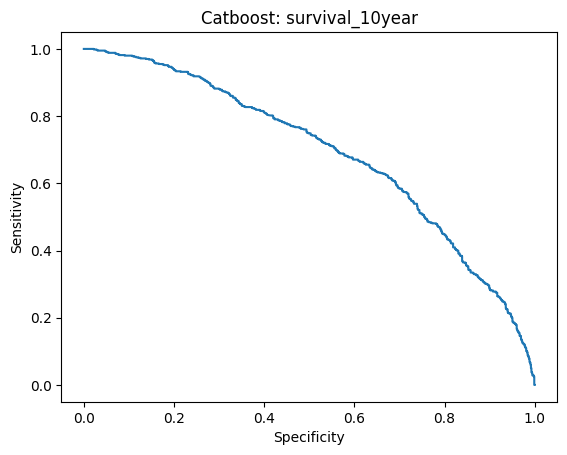

AUC=0.690
Best balanced accuracy: 0.649
Brier Score Loss: 0.21580
C-Index: 0.630


In [337]:
from catboost import CatBoostClassifier
from experimental_utils import make_catboost
    
# Test-based data ablation
model = make_catboost('params_clinimage')
# model = make_catboost('params_clinimage2')
model = make_catboost('params_fast')
ablation_fraction = 0.00 #0.05 best without image data
if ablation_fraction:
    X_train_p, y_train_p = filter_lowvalue_data(X_train, y_train, model, categorical, fraction=ablation_fraction)
else:
    X_train_p, y_train_p = X_train, y_train
print("With X_train filtering at {}%: {}".format(ablation_fraction * 100, X_train_p.shape))

model.fit(X_train_p,
          y_train_p,
          cat_features=categorical,
          eval_set=(X_test, y_test),
          plot=True
         ) #chooses best model for this eval set.
probs = model.predict_proba(X_test)[:,1]
plot_ss_curve(y_test, probs, title="Catboost: {}".format(y_var))
print("Brier Score Loss: {:0.5f}".format(brier_score_loss(y_test, probs)))

# C-Index of endpoint & endpoint_times (e.g. distant_met & distant_met_years), with model trained on distant_met_Nyear
#lifelines.utils.concordance_index(event_times, predicted_scores, event_observed=None) → float
yt = meta_test[[endpoint]].values.copy()
yt[yt==2] = 0
print("C-Index: {:0.3f}".format(
    concordance_index(meta_test[[endpoint_times]], model.predict_proba(X_test)[:,0], event_observed=yt)
))

In [251]:
# Performance on subsets of testset

def compute_subset(xt, yt):
    nccn_model = NCCN()
    gt, probs = yt[y_var].values, nccn_model.predict_proba(xt, outcome=y_var)
    fpr, tpr, thresholds = metrics.roc_curve(gt, probs, pos_label=1)
    nccn_auc = metrics.auc(fpr, tpr)

    gt, probs = yt, model.predict_proba(xt)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(gt, probs, pos_label=1)
    catboost_auc = metrics.auc(fpr, tpr)
    
    return nccn_auc, catboost_auc

def compute_subset_brier(xt, yt):
    nccn_model = NCCN()
    gt, probs = yt[y_var].values, nccn_model.predict_proba(xt, outcome=y_var)
    nccn_brier = brier_score_loss(gt, probs)

    gt, probs = yt, model.predict_proba(xt)[:,1]
    catboost_brier = brier_score_loss(gt, probs)
    
    return nccn_brier, catboost_brier


def compute_subset_concordance(X, E, T):
    nccn_model = NCCN()
    nccn_concordance = concordance_index(T, 
                                         1-nccn_model.predict_proba(X, outcome=y_var), 
                                         event_observed=E)
    catboost_concordance = concordance_index(T, 
                                         model.predict_proba(X)[:,0], 
                                         event_observed=E)
    return nccn_concordance, catboost_concordance


def subset_performance_auc(var_name="sn"):
    for var in X_test_full[var_name].unique():
        if np.isnan(var):
            continue
        xt = X_test[X_test_full[var_name] == var]
        yt = y_test[X_test_full[var_name] == var]
        nccn_auc, catboost_auc = compute_subset(xt, yt)
        print("{}={}, y_var={}, N={}, NCCN={:0.3f}, Catboost={:0.3f}, Rel Improve = {:0.3f}".format(
            var_name, var, y_var, sum(yt.values), nccn_auc, catboost_auc, catboost_auc/nccn_auc - 1,
        ))
        
        
def subset_performance_auc_imaged():
    f = [col for col in X_test.columns if len(col)<=4 and col[0] == 'f']
    ims = X_test[f].abs().sum(axis=1) != 0
    xt = X_test[ims]
    yt = y_test[ims]
    nccn_auc, catboost_auc = compute_subset(xt, yt)
    print("Imaged Subset: {}, y_var={}, N={}, NCCN={:0.3f}, Catboost={:0.3f}, Rel Improve = {:0.3f}".format(
        len(xt), y_var, sum(yt.values), nccn_auc, catboost_auc, catboost_auc/nccn_auc - 1,
    ))

    
def subset_performance_concordance(var_name="sn"):
    for var in X_test_full[var_name].unique():
        X = X_test[X_test_full[var_name] == var]
        E = meta_test[[endpoint]].values.copy()
        E = E[X_test_full[var_name] == var]
        E[E==2] = 0
        T = meta_test[[endpoint_times]].values.copy()
        T = T[X_test_full[var_name] == var]
        
        nccn_concordance, catboost_concordance = compute_subset_concordance(X, E, T)
        print("{}={}, y_var={}, N={}, NCCN-C={:0.3f}, Catboost-C={:0.3f}, Rel Improve = {:0.3f}".format(
            var_name, var, y_var, sum(E), 
            nccn_concordance, catboost_concordance, catboost_concordance/nccn_concordance - 1,
        ))
        
def subset_performance_concordance_imaged():
    f = [col for col in X_test.columns if len(col)<=4 and col[0] == 'f']
    ims = X_test[f].abs().sum(axis=1) != 0
    X = X_test[ims]
    E = meta_test[[endpoint]].values.copy()
    E = E[ims]
    E[E==2] = 0
    T = meta_test[[endpoint_times]].values.copy()
    T = T[ims]

    nccn_concordance, catboost_concordance = compute_subset_concordance(X, E, T)
    print("Imaged Subset: {}, y_var={}, N={}, NCCN-C={:0.3f}, Catboost-C={:0.3f}, Rel Improve = {:0.3f}".format(
        len(X), y_var, sum(E), 
        nccn_concordance, catboost_concordance, catboost_concordance/nccn_concordance - 1,
    ))
    
    
def subset_performance_brier(var_name="sn"):
    for var in X_test_full[var_name].unique():
        if np.isnan(var):
            continue
        xt = X_test[X_test_full[var_name] == var]
        yt = y_test[X_test_full[var_name] == var]
        nccn_brier, catboost_brier = compute_subset_brier(xt, yt)
        print("{}={}, y_var={}, N={}, NCCN-B={:0.5f}, Catboost-B={:0.5f}, Rel Decrease = {:0.5f}".format(
            var_name, var, y_var, sum(yt.values), nccn_brier, catboost_brier, (nccn_brier - catboost_brier)/nccn_brier,
        ))
    
    
subset_performance_auc('sn'); print()
# subset_performance_imaged(); print()
subset_performance_concordance('sn'); print()
# subset_concordance_imaged(); print()
subset_performance_brier('sn'); print()

sn=126.0, y_var=distant_met_5year, N=[11], NCCN=0.682, Catboost=0.725, Rel Improve = 0.062
sn=9202.0, y_var=distant_met_5year, N=[32], NCCN=0.620, Catboost=0.717, Rel Improve = 0.155
sn=9413.0, y_var=distant_met_5year, N=[28], NCCN=0.601, Catboost=0.741, Rel Improve = 0.233
sn=9910.0, y_var=distant_met_5year, N=[9], NCCN=0.688, Catboost=0.853, Rel Improve = 0.239
sn=9408.0, y_var=distant_met_5year, N=[15], NCCN=0.778, Catboost=0.895, Rel Improve = 0.151

sn=126.0, y_var=distant_met_5year, N=[29.], NCCN-C=0.624, Catboost-C=0.730, Rel Improve = 0.169
sn=9202.0, y_var=distant_met_5year, N=[58.], NCCN-C=0.586, Catboost-C=0.687, Rel Improve = 0.172
sn=9413.0, y_var=distant_met_5year, N=[48.], NCCN-C=0.606, Catboost-C=0.710, Rel Improve = 0.171
sn=9910.0, y_var=distant_met_5year, N=[19.], NCCN-C=0.677, Catboost-C=0.805, Rel Improve = 0.190
sn=9408.0, y_var=distant_met_5year, N=[34.], NCCN-C=0.659, Catboost-C=0.746, Rel Improve = 0.132

sn=126.0, y_var=distant_met_5year, N=[11], NCCN-B=0.0337

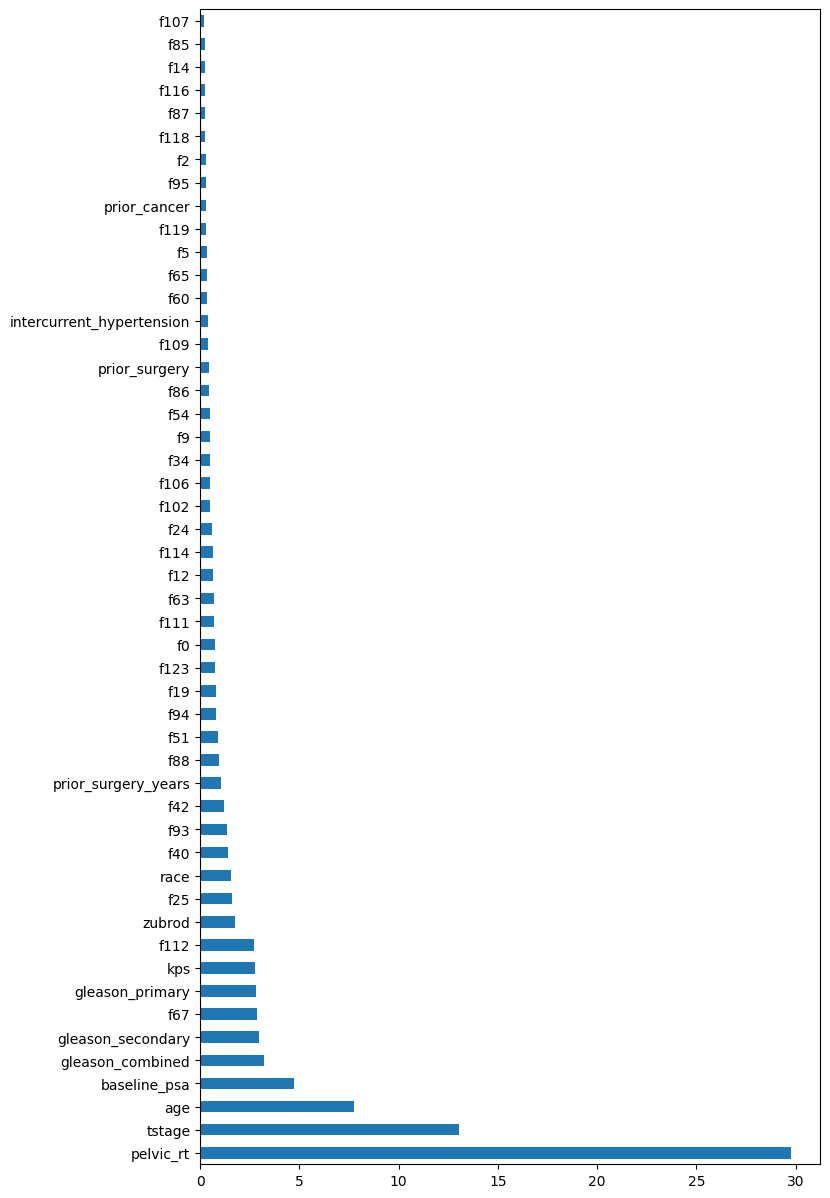

rx            0.000000
pelvic_rt    29.740578
dtype: float64

In [29]:
feat_imp = pd.Series(model.feature_importances_, index=df_X.columns)
feat_imp.nlargest(50).plot(kind='barh', figsize=(8,15))
plt.show()

# Print rx importance relative to max
feat_imp[['rx', feat_imp[feat_imp.values == feat_imp.max()].keys()[0]]]

### NCCN Model

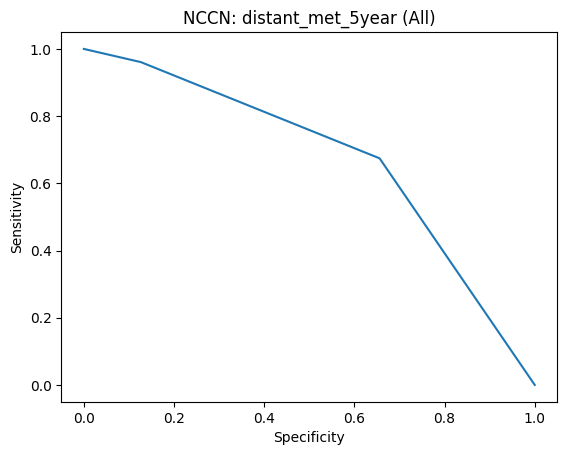

AUC=0.673
Best balanced accuracy: 0.665



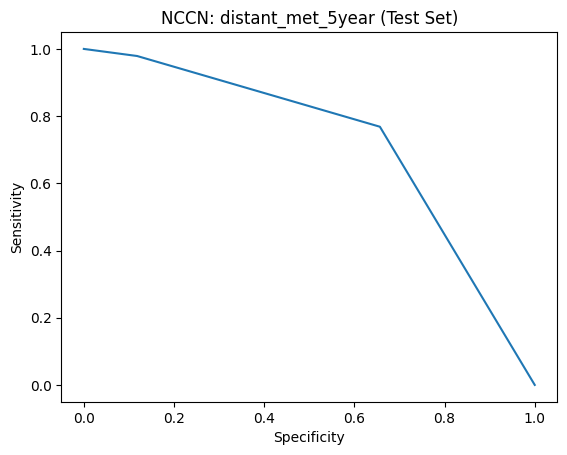

AUC=0.719
Best balanced accuracy: 0.713
Concordance: 0.669


In [252]:
from clin_utils import NCCN

nccn_model = NCCN()

plot_ss_curve(df_y[y_var].values, 
              nccn_model.predict_proba(df_X, outcome=y_var), 
              title="NCCN: {} (All)".format(y_var))
print()

plot_ss_curve(y_test[y_var].values, 
              nccn_model.predict_proba(X_test, outcome=y_var), 
              title="NCCN: {} (Test Set)".format(y_var))

yt = meta_test[[endpoint]].values.copy()
yt[yt==2] = 0
print("Concordance: {:0.3f}".format(
    concordance_index(meta_test[[endpoint_times]], 1-nccn_model.predict_proba(X_test, outcome=y_var), event_observed=yt)
))

## Prognostic Biomarker: C-index
 - Following [PySurvival](https://square.github.io/pysurvival/index.html])

### Catboost Classifier trained on endpoint
 - e.g. train on distant_met instead of distant_met_5year

In [126]:
from lifelines.utils import concordance_index
from objectives import CoxPHMetric, CoxPHObjective
from catboost import CatBoostRegressor

# C-Index of endpoint & endpoint_times (e.g. distant_met & distant_met_years), with model trained on distant_met
# Competing Risks are censored

params_fast = {'iterations':650, 'learning_rate':0.1, 'depth':2, 'verbose':False, 'thread_count':4, 'one_hot_max_size':10, 'train_dir' : '/tmp/catboost_info'}
# params_clinimage = {'iterations':16000, 'early_stopping_rounds':1000, 'learning_rate':0.003, 'depth':5, 'l2_leaf_reg' : 10, 'verbose':False, 'thread_count':4, 'one_hot_max_size':10, 'train_dir' : '/tmp/catboost_info'}

# params = params_clinimage
params = params_fast
model = CatBoostClassifier(**params, eval_metric="AUC") # eval metric could be concordance. 

# To train on events
mtrain = meta_train[[endpoint]].values.copy()
mtrain[mtrain==2] = 0
mtest = meta_test[[endpoint]].values.copy()
mtest[mtest==2] = 0


model.fit(X_train,
          mtrain,
          cat_features=categorical,
          eval_set=(X_test, mtest),
          plot=True
         ) #chooses best model for this eval set.
c = concordance_index(meta_test[[endpoint_times]], model.predict_proba(X_test)[:,0], mtest)
print("C-Index: {}".format(c))


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

C-Index: 0.7518560893102133


In [123]:
concordance_index(meta_test[[endpoint_times]].values.copy(), model.predict_proba(X_test)[:,0], mtest)

0.7518560893102133

### Catboost Regressor trained on endpoint times

In [107]:
from lifelines.utils import concordance_index
from objectives import CoxPHMetric, CoxPHObjective
from catboost import CatBoostRegressor

# C-Index of endpoint & endpoint_times (e.g. distant_met & distant_met_years), with model trained on distant_met
# Competing Risks are censored

params_fast = {'iterations':650, 'learning_rate':0.1, 'depth':2, 'verbose':False, 'thread_count':4, 'one_hot_max_size':10, 'train_dir' : '/tmp/catboost_info'}
# params_clinimage = {'iterations':16000, 'early_stopping_rounds':1000, 'learning_rate':0.003, 'depth':5, 'l2_leaf_reg' : 10, 'verbose':False, 'thread_count':4, 'one_hot_max_size':10, 'train_dir' : '/tmp/catboost_info'}

# params = params_clinimage
params = params_fast
model = CatBoostRegressor(**params)#, eval_metric="RMSE")

# To train on event times
def prep(meta):
    m = meta[endpoint_times].values.copy()
    idx = meta[endpoint].values.copy()
    idx[idx == 2] =0
    m[idx] = -m[idx]
    return m
mtrain = prep(meta_train)
mtest = prep(meta_test)

model.fit(X_train,
          mtrain,
          cat_features=categorical,
          eval_set=(X_test, mtest),
          plot=True
         ) #chooses best model for this eval set.
c = concordance_index(meta_test[[endpoint_times]], model.predict(X_test), meta_test[[endpoint]])
print("C-Index: {}".format(c))


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

C-Index: 0.5899699465273236


### Catboost Classifier w/ CoxPH eval_metric
 - not working

In [108]:
from lifelines.utils import concordance_index
from objectives import CoxPHMetric, CoxPHObjective
from catboost import CatBoostRegressor

# C-Index of endpoint & endpoint_times (e.g. distant_met & distant_met_years), with model trained on distant_met
# Competing Risks are censored

params_fast = {'iterations':650, 'learning_rate':0.1, 'depth':2, 'verbose':False, 'thread_count':4, 'one_hot_max_size':10, 'train_dir' : '/tmp/catboost_info'}
# params_clinimage = {'iterations':16000, 'early_stopping_rounds':1000, 'learning_rate':0.003, 'depth':5, 'l2_leaf_reg' : 10, 'verbose':False, 'thread_count':4, 'one_hot_max_size':10, 'train_dir' : '/tmp/catboost_info'}

# params = params_clinimage
params = params_fast
model = CatBoostClassifier(**params, eval_metric=CoxPHMetric()) # eval metric should be concordance. 

# To train on events
mtrain = meta_train[[endpoint]].values.copy()
mtrain[mtrain==2] = 0
mtest = meta_test[[endpoint]].values.copy()
mtest[mtest==2] = 0

model.fit(X_train,
          mtrain,
          cat_features=categorical,
          eval_set=(X_test, mtest),
          plot=True
         ) #chooses best model for this eval set.
c = concordance_index(meta_test[[endpoint_times]], model.predict_proba(X_test)[:,0], mtest)
print("C-Index: {}".format(c))

#TODO: Insert R code, with Rpy2, to compute c-index using competing risks. Comment out the ==2 lines, above.


Can't optimze method "evaluate" because self argument is used


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

C-Index: 0.7436169843934959


In [64]:
concordance_index(meta_test[[endpoint_times]], model.predict_proba(X_test)[:,0], mtest)
concordance_index(meta_test[[endpoint_times]], meta_test[[endpoint_times]], mtest)

0.9999727591962477

In [49]:
model.predict(X_test).shap

(1551,)

### Catboost Classifier w/ Concordance as eval metric

In [93]:
from lifelines.utils import concordance_index

# WHENCE: This buggy
class ConcordanceIndex(object):
    def __init__(self, T, E):
        self.T = T
        self.E = E
        
        
    def is_max_optimal(self):
        return True
    
    
    def evaluate(self, approxes, target, weight):
            # approxes is a list of indexed containers
            # (containers with only __len__ and __getitem__ defined),
            # one container per approx dimension.
            # Each container contains floats.
            # weight is a one dimensional indexed container.
            # target is a one dimensional indexed container.

            # weight parameter can be None.
            # Returns pair (error, weights sum)
            assert len(approxes) == 1
            assert len(target) == len(approxes[0])

            approx = approxes[0]

            approx = np.asarray(approx, dtype=np.float64)
            target = np.asarray(target, dtype=np.float64)
            if weight is not None:
                weight = np.asarray(weight, dtype=np.float64)
                
            T, E = self.T, self.E
            return concordance_index(T, approx, E)
            

In [96]:
from lifelines.utils import concordance_index
from objectives import CoxPHMetric
from catboost import CatBoostRegressor


# To train on events
mtrain = meta_train[[endpoint]].values.copy()
mtrain[mtrain==2] = 0
mtest = meta_test[[endpoint]].values.copy()
mtest[mtest==2] = 0

# Build Model
params_fast = {'iterations':150, 'learning_rate':0.1, 'depth':2, 'verbose':False, 'thread_count':4, 'one_hot_max_size':10, 'train_dir' : '/tmp/catboost_info'}
params_clinimage = {'iterations':16000, 'early_stopping_rounds':1000, 'learning_rate':0.003, 'depth':5, 'l2_leaf_reg' : 10, 'verbose':False, 'thread_count':4, 'one_hot_max_size':10, 'train_dir' : '/tmp/catboost_info'}

# params = params_clinimage
params = params_fast
model = CatBoostClassifier(**params, eval_metric=ConcordanceIndex(E=mtest, T=meta_test[endpoint_times]))

# Train Model
model.fit(X_train,
          mtrain,
          cat_features=categorical,
          eval_set=(X_test, mtest),
          plot=True
         ) #chooses best model for this eval set.
c = concordance_index(meta_test[[endpoint_times]], model.predict_proba(X_test)[:,0], mtest)
print("C-Index: {}".format(c))

#TODO: Insert R code, with Rpy2, to compute c-index using competing risks. Comment out the ==2 lines, above.


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostError: catboost/python-package/catboost/helpers.cpp:42: Traceback (most recent call last):
  File "_catboost.pyx", line 1315, in _catboost._MetricEval
  File "<ipython-input-93-bacf45001c2b>", line 34, in evaluate
    return concordance_index(T, approx, E)
  File "/home/user/miniconda/envs/py36/envs/py37/lib/python3.7/site-packages/lifelines/utils/concordance.py", line 91, in concordance_index
    event_times, predicted_scores, event_observed = _preprocess_scoring_data(event_times, predicted_scores, event_observed)
  File "/home/user/miniconda/envs/py36/envs/py37/lib/python3.7/site-packages/lifelines/utils/concordance.py", line 287, in _preprocess_scoring_data
    raise ValueError("Event times and predictions must have the same shape")
ValueError: Event times and predictions must have the same shape


### Catboost trained on DM, sent to Jean for C-index with competing risks in R
 - AUC of 0.754

In [74]:
# C-Index of endpoint & endpoint_times (e.g. distant_met & distant_met_years), with model trained on distant_met
# (currently can't properly compute in python, so save and send to Jean)
from lifelines.utils import concordance_index

model = make_catboost('params_clinimage')
# model = make_catboost('params_clinimage_multiclass')
# model = make_catboost('params_clinimage2')
# model = make_catboost('params_fast')

mtrain = meta_train[[endpoint]].values.copy()
mtest = meta_test[[endpoint]].values.copy()

model.fit(X_train,
          mtrain,
          cat_features=categorical,
          eval_set=(X_test, mtest),
          plot=True
         ) #chooses best model for this eval set.
probs = model.predict_proba(X_test)

#TODO: Insert R code, with Rpy2, to compute c-index using competing risks. Comment out the ==2 lines, above.

Making Catboost: params_clinimage


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
df = pd.DataFrame(np.concatenate((probs, mtest, meta_test[[endpoint_times]].values.copy()), axis=1), 
             columns=['p0', 'p1', 'p2', endpoint, endpoint_times])
df

In [174]:
df.to_csv("./distant_met_predictions.csv")

# Predictive Biomarker (NEJM / Lancet)


(array([1., 0., 0., ..., 0., 1., 1.]),
 array([0.00020846, 0.00021211, 0.00021575, ..., 0.00457188, 0.00457552,
        0.00457917]))

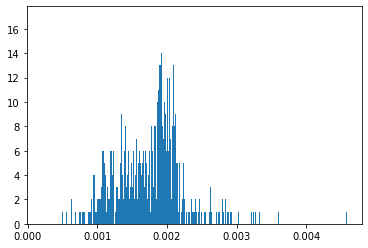

In [570]:
num_bins = 1200
# num_bins = 2400

def toggle(df_prev, field):
    df = df_prev.copy()
    vals = df[field].unique()
    assert len(vals) == 2, "Can't toggle non-binary therapies, {}".format(len(vals))
    d = {vals[0] : vals[1], vals[1]: vals[0]}
    rx_toggle = [d[v] for v in df[field].values]
    df[field] = rx_toggle
    assert not any(df[field].values == df_prev[field].values)
    return df

class Group(object):
    def __init__(self, df_X, df_y):
        self.df_X = df_X
        self.df_y = df_y
        self.rx = sorted(df_X['rx'].unique())
        assert len(self.rx) == 2, "Groups without exactly 2 rx not supported: {}".format(self.rx)
        
    def binary_hazard_ratio(self):
        y0 = self.df_y[self.df_X['rx'] == self.rx[0]]
        mu0 = np.mean(y0)
        sigma0 = np.std(y0)
        
        y1 = self.df_y[self.df_X['rx'] == self.rx[1]]
        mu1 = np.mean(y1)
        sigma1 = np.std(y1)
        
        hr = mu1 / mu0
        return hr
        
X_test_toggle = toggle(X_test, 'rx')
probs = model.predict_proba(X_test)[:,1]
probs_toggle = model.predict_proba(X_test_toggle)[:,1]
delta_probs = np.abs(probs - probs_toggle)
counts, bins, _ = plt.hist(delta_probs, bins=num_bins)
counts, bins

In [571]:
### Binary HR

# The below settings assume num_bins=1200

# 9408 
idx = 5 # Best for 9408 with dm == 2 -> 1
# idx = 2 # Best for 9408 with dm == 2 clipped out
idx = 479

# 9202
# idx = 322 # Best for 9202 with dm == 2 -> 1
# idx = 249 # Best for 9202 with dm ==2 clipped out
# idx = 40 # 9202 trained with params_fast
# idx = 152 # Best for 9202 trained with params fast. Dm ==2 -> 0
# idx = 300

cutoff = bins[idx]
n0 = np.sum(counts[0:idx])
n1 = np.sum(counts[idx:])
print("Group 0, N={}".format(n0))
print("Group 1, N={}".format(n1))
print("Cutoff:{:0.4f}, Index={} of {}".format(cutoff, idx, num_bins))
print()
    
g0 = Group(X_test[delta_probs <= cutoff], y_test[delta_probs <= cutoff])
g1 = Group(X_test[delta_probs > cutoff], y_test[delta_probs > cutoff])

print("Binary Results:")
print("Biomarker Negative HR: {:0.4f}".format(g0.binary_hazard_ratio().values[0]))
print("Biomarker Positive HR: {:0.4f}".format(g1.binary_hazard_ratio().values[0]))


Group 0, N=1299.0
Group 1, N=675.0
Cutoff:0.0020, Index=479 of 1200

Binary Results:
Biomarker Negative HR: 1.0778
Biomarker Positive HR: 0.2151


In [576]:
# Prep Data for continous HR
data = X_test_full.copy()
outcome_years = '{}_years'.format(outcome)
data[outcome_years] = np.copy(meta_test[outcome_years].values)
data['biomarker'] = 0
data.loc[delta_probs > cutoff, 'biomarker'] = 1

# data['biomarker'] = np.log(delta_probs + 1)
# data['biomarker'] = delta_probs
data['rx'] = data[['rx']].astype(int)

# WARNING: Make sure this status is 0 for censored, 1 otherwise
status = np.copy(meta_test[outcome].values)
status[status == 2] = 0

# Clip out patients with competing events
# data = data[status != 2]
# status = status[status != 2]

# Group sizes
n1 = sum(data['biomarker'])
n0 = len(data) - n1

data[['rx', 'biomarker']]
sum(status)

164

In [577]:
# data.to_csv("./data.csv")
# np.savetxt("./status.csv", status, delimiter=",")

In [578]:
import statsmodels
from statsmodels.duration.survfunc import SurvfuncRight

smod = SurvfuncRight(data[outcome_years], status, title="Cumulative Incidence of {}".format(outcome))
smod.summary()

Surv prob  Surv prob SE  num at risk  num events
Time                                                       
0.575342    0.999490      0.000510         1961         1.0
0.594521    0.998980      0.000721         1959         1.0
0.758904    0.998467      0.000885         1947         1.0
0.901370    0.997951      0.001023         1937         1.0
0.921566    0.997436      0.001145         1936         1.0
...              ...           ...          ...         ...
17.308047   0.853395      0.012875          255         1.0
17.512329   0.849869      0.013296          242         1.0
17.586728   0.846237      0.013726          234         1.0
17.627495   0.842574      0.014147          231         1.0
17.940879   0.838340      0.014696          199         1.0

[164 rows x 4 columns]

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: PHReg
==================================================================
Model:                   PH Reg               Sample size:    1961
Dependent variable:      distant_met_years    Num. events:    164 
Ties:                    Efron                                    
------------------------------------------------------------------
              log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------------
biomarker     0.6279    0.2020 1.8736  3.1076 0.0019 1.2610 2.7839
rx           -0.0740    0.2042 0.9287 -0.3624 0.7170 0.6223 1.3858
biomarker:rx -0.8936    0.3387 0.4092 -2.6380 0.0083 0.2107 0.7948
==================================================================
Confidence intervals are for the hazard ratios
"""


Test Set: [9408]
Hazard Ratio of biomarker negative group: 0.9287 (n=1299)
Hazard Ratio of biomarker positive group: 0.7120 (n=675)
p-value: 0.0083
Cutoff:0.0020, Index=[False False False ...  True False  True] of 1200



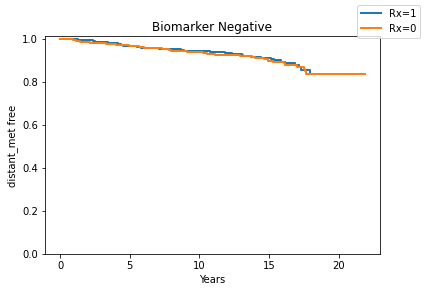

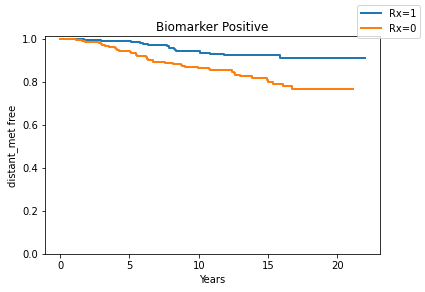

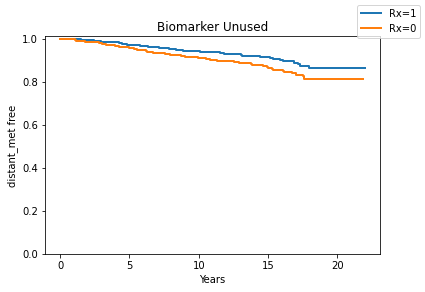

In [579]:
# Following https://www.statsmodels.org/stable/duration.html#regression-methods
import statsmodels.api as sm
import statsmodels.formula.api as smf
mod = smf.phreg("{} ~ biomarker + rx + biomarker * rx".format(outcome_years), 
                data, 
                status=status, 
                ties="efron")
rslt = mod.fit()
display(rslt.summary())
print()

log_hr = rslt.params
print("Test Set: {}".format(studies_test))
print("Hazard Ratio of biomarker negative group: {:0.4f} (n={})".format(
    rslt.summary().tables[1].loc['rx', 'HR'], 
    n0
))
print("Hazard Ratio of biomarker positive group: {:0.4f} (n={})".format(
    np.prod(rslt.summary().tables[1]['HR'].values),
    n1
))
print("p-value: {:0.4f}".format(rslt.summary().tables[1].loc['biomarker:rx', 'P>|t|']))
print("Cutoff:{:0.4f}, Index={} of {}".format(cutoff, idx, num_bins))
print()

for b in list(data['biomarker'].unique()) + [2]:
    f = plt.figure()
    f.add_subplot()
    ax = f.get_axes()[0]
    ax.set_title("Biomarker {}".format(['Negative', 'Positive', 'Unused'][b]))
    ax.set_xlabel("Years")
    ax.set_ylabel("{} free".format(outcome))
    for rx_i in data['rx'].unique():
        if b == 2:
            pass
            idx = (data['rx'] == rx_i).values
        else:
            idx = (data['biomarker'] == b).values & (data['rx'] == rx_i).values
        d = data[idx]
        s = status[idx]
        sf = sm.SurvfuncRight(d[outcome_years], s)    
        sf.plot(ax)

    li = ax.get_lines()
    li[1].set_visible(False)
    li[3].set_visible(False)
    f.legend((li[0], li[2]), 
             ("Rx={}".format(data['rx'].unique()[0]), "Rx={}".format(data['rx'].unique()[1])),
             loc='upper right'
            )
    f.show()

In [398]:
#TMP - run a loop over the above cells

# idx = 120 # 9910

results = {}
for idx in range(1, 500, 1):
    cutoff = bins[idx]
    n0 = np.sum(counts[0:idx])
    n1 = np.sum(counts[idx:])
    # --------
    # Prep Data for continous HR
    data = X_test_full.copy()
    outcome_years = '{}_years'.format(outcome)
    data[outcome_years] = np.copy(meta_test[outcome_years].values)
    data['biomarker'] = 0
    data.loc[delta_probs > cutoff, 'biomarker'] = 1
    data['rx'] = data[['rx']].astype(int)

    # WARNING: Make sure this status is 0 for censored, 1 otherwise
    status = np.copy(meta_test[outcome].values)
    status[status == 2] = 0

#     data = data[status != 2]
#     status = status[status != 2]

    # ---------
    mod = smf.phreg("{} ~ biomarker + rx + biomarker * rx".format(outcome_years), 
                    data, 
                    status=status, 
                    ties="efron")
    rslt = mod.fit()

    log_hr = rslt.params
    print("Hazard Ratio of biomarker negative group: {:0.4f} (n={})".format(
        rslt.summary().tables[1].loc['rx', 'HR'], 
        n0
    ))
    print("Hazard Ratio of biomarker positive group: {:0.4f} (n={})".format(
        np.prod(rslt.summary().tables[1]['HR'].values),
        n1
    ))
    pvalue = rslt.summary().tables[1].loc['biomarker:rx', 'P>|t|']
    print("p-value: {:0.4f}".format(pvalue))
    print("Cutoff:{:0.4f}, Index={} of {}".format(cutoff, idx, num_bins))
    print("-------------")
    results[pvalue] = idx

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt


Hazard Ratio of biomarker negative group: 0.0538 (n=1.0)
Hazard Ratio of biomarker positive group: 137.3148 (n=1519.0)
p-value: nan
Cutoff:0.0008, Index=1 of 1200
-------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt


Hazard Ratio of biomarker negative group: 0.0538 (n=1.0)
Hazard Ratio of biomarker positive group: 137.3148 (n=1519.0)
p-value: nan
Cutoff:0.0008, Index=2 of 1200
-------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt


Hazard Ratio of biomarker negative group: 0.0538 (n=1.0)
Hazard Ratio of biomarker positive group: 137.3148 (n=1519.0)
p-value: nan
Cutoff:0.0008, Index=3 of 1200
-------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt


Hazard Ratio of biomarker negative group: 0.0538 (n=1.0)
Hazard Ratio of biomarker positive group: 137.3148 (n=1519.0)
p-value: nan
Cutoff:0.0009, Index=4 of 1200
-------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt


Hazard Ratio of biomarker negative group: 0.0538 (n=1.0)
Hazard Ratio of biomarker positive group: 137.3148 (n=1519.0)
p-value: nan
Cutoff:0.0009, Index=5 of 1200
-------------


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater


Hazard Ratio of biomarker negative group: nan (n=2.0)
Hazard Ratio of biomarker positive group: nan (n=1518.0)
p-value: nan
Cutoff:0.0009, Index=6 of 1200
-------------


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater


Hazard Ratio of biomarker negative group: nan (n=2.0)
Hazard Ratio of biomarker positive group: nan (n=1518.0)
p-value: nan
Cutoff:0.0009, Index=7 of 1200
-------------


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater


Hazard Ratio of biomarker negative group: nan (n=2.0)
Hazard Ratio of biomarker positive group: nan (n=1518.0)
p-value: nan
Cutoff:0.0009, Index=8 of 1200
-------------


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater


Hazard Ratio of biomarker negative group: nan (n=2.0)
Hazard Ratio of biomarker positive group: nan (n=1518.0)
p-value: nan
Cutoff:0.0009, Index=9 of 1200
-------------


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater


Hazard Ratio of biomarker negative group: nan (n=2.0)
Hazard Ratio of biomarker positive group: nan (n=1518.0)
p-value: nan
Cutoff:0.0009, Index=10 of 1200
-------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
overflow encountered in exp


Hazard Ratio of biomarker negative group: 0.0001 (n=3.0)
Hazard Ratio of biomarker positive group: 32708035.8572 (n=1517.0)
p-value: 1.0000
Cutoff:0.0009, Index=11 of 1200
-------------


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater


Hazard Ratio of biomarker negative group: nan (n=4.0)
Hazard Ratio of biomarker positive group: nan (n=1516.0)
p-value: nan
Cutoff:0.0009, Index=12 of 1200
-------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
overflow encountered in exp


Hazard Ratio of biomarker negative group: 0.0854 (n=6.0)
Hazard Ratio of biomarker positive group: 325494271464.6376 (n=1514.0)
p-value: 1.0000
Cutoff:0.0009, Index=13 of 1200
-------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
overflow encountered in exp


Hazard Ratio of biomarker negative group: 0.0854 (n=6.0)
Hazard Ratio of biomarker positive group: 325494271464.6376 (n=1514.0)
p-value: 1.0000
Cutoff:0.0009, Index=14 of 1200
-------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
overflow encountered in exp


Hazard Ratio of biomarker negative group: 0.0854 (n=6.0)
Hazard Ratio of biomarker positive group: 325494271464.6376 (n=1514.0)
p-value: 1.0000
Cutoff:0.0010, Index=15 of 1200
-------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
overflow encountered in exp


Hazard Ratio of biomarker negative group: 0.0854 (n=6.0)
Hazard Ratio of biomarker positive group: 325494271464.6376 (n=1514.0)
p-value: 1.0000
Cutoff:0.0010, Index=16 of 1200
-------------


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater


Hazard Ratio of biomarker negative group: nan (n=7.0)
Hazard Ratio of biomarker positive group: nan (n=1513.0)
p-value: nan
Cutoff:0.0010, Index=17 of 1200
-------------


divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater


Hazard Ratio of biomarker negative group: nan (n=7.0)
Hazard Ratio of biomarker positive group: nan (n=1513.0)
p-value: nan
Cutoff:0.0010, Index=18 of 1200
-------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt


Hazard Ratio of biomarker negative group: 0.3581 (n=10.0)
Hazard Ratio of biomarker positive group: 726397763780.4094 (n=1510.0)
p-value: nan
Cutoff:0.0010, Index=19 of 1200
-------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt


Hazard Ratio of biomarker negative group: 0.3581 (n=10.0)
Hazard Ratio of biomarker positive group: 726397763780.4094 (n=1510.0)
p-value: nan
Cutoff:0.0010, Index=20 of 1200
-------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt


Hazard Ratio of biomarker negative group: 0.0044 (n=11.0)
Hazard Ratio of biomarker positive group: 1348250051.7716 (n=1509.0)
p-value: nan
Cutoff:0.0010, Index=21 of 1200
-------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
overflow encountered in exp


Hazard Ratio of biomarker negative group: 0.0000 (n=12.0)
Hazard Ratio of biomarker positive group: 0.0000 (n=1508.0)
p-value: 1.0000
Cutoff:0.0010, Index=22 of 1200
-------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
overflow encountered in exp


Hazard Ratio of biomarker negative group: 0.0000 (n=12.0)
Hazard Ratio of biomarker positive group: 0.0000 (n=1508.0)
p-value: 1.0000
Cutoff:0.0010, Index=23 of 1200
-------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
overflow encountered in exp


Hazard Ratio of biomarker negative group: 0.0000 (n=12.0)
Hazard Ratio of biomarker positive group: 0.0000 (n=1508.0)
p-value: 1.0000
Cutoff:0.0010, Index=24 of 1200
-------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
overflow encountered in exp


Hazard Ratio of biomarker negative group: 0.0000 (n=12.0)
Hazard Ratio of biomarker positive group: 0.0000 (n=1508.0)
p-value: 1.0000
Cutoff:0.0011, Index=25 of 1200
-------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
overflow encountered in exp


Hazard Ratio of biomarker negative group: 0.0000 (n=13.0)
Hazard Ratio of biomarker positive group: 0.0000 (n=1507.0)
p-value: 0.9998
Cutoff:0.0011, Index=26 of 1200
-------------
Hazard Ratio of biomarker negative group: 2.7258 (n=14.0)
Hazard Ratio of biomarker positive group: 8.5142 (n=1506.0)
p-value: 0.2989
Cutoff:0.0011, Index=27 of 1200
-------------
Hazard Ratio of biomarker negative group: 3.4047 (n=16.0)
Hazard Ratio of biomarker positive group: 13.3328 (n=1504.0)
p-value: 0.2308
Cutoff:0.0011, Index=28 of 1200
-------------
Hazard Ratio of biomarker negative group: 2.3756 (n=17.0)
Hazard Ratio of biomarker positive group: 9.3019 (n=1503.0)
p-value: 0.3455
Cutoff:0.0011, Index=29 of 1200
-------------
Hazard Ratio of biomarker negative group: 2.3756 (n=17.0)
Hazard Ratio of biomarker positive group: 9.3019 (n=1503.0)
p-value: 0.3455
Cutoff:0.0011, Index=30 of 1200
-------------
Hazard Ratio of biomarker negative group: 2.3756 (n=17.0)
Hazard Ratio of biomarker positive group:

Hazard Ratio of biomarker negative group: 1.2506 (n=96.0)
Hazard Ratio of biomarker positive group: 4.0393 (n=1424.0)
p-value: 0.2654
Cutoff:0.0015, Index=72 of 1200
-------------
Hazard Ratio of biomarker negative group: 1.0326 (n=98.0)
Hazard Ratio of biomarker positive group: 2.7898 (n=1422.0)
p-value: 0.4000
Cutoff:0.0015, Index=73 of 1200
-------------
Hazard Ratio of biomarker negative group: 1.0313 (n=104.0)
Hazard Ratio of biomarker positive group: 3.0060 (n=1416.0)
p-value: 0.3998
Cutoff:0.0015, Index=74 of 1200
-------------
Hazard Ratio of biomarker negative group: 1.3122 (n=111.0)
Hazard Ratio of biomarker positive group: 4.2196 (n=1409.0)
p-value: 0.1886
Cutoff:0.0015, Index=75 of 1200
-------------
Hazard Ratio of biomarker negative group: 1.3012 (n=115.0)
Hazard Ratio of biomarker positive group: 4.3884 (n=1405.0)
p-value: 0.1930
Cutoff:0.0015, Index=76 of 1200
-------------
Hazard Ratio of biomarker negative group: 1.1011 (n=123.0)
Hazard Ratio of biomarker positive gro

Hazard Ratio of biomarker negative group: 0.6418 (n=330.0)
Hazard Ratio of biomarker positive group: 1.5544 (n=1190.0)
p-value: 0.9387
Cutoff:0.0019, Index=118 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6471 (n=334.0)
Hazard Ratio of biomarker positive group: 1.6113 (n=1186.0)
p-value: 0.9129
Cutoff:0.0019, Index=119 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6456 (n=341.0)
Hazard Ratio of biomarker positive group: 1.6425 (n=1179.0)
p-value: 0.9191
Cutoff:0.0019, Index=120 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6456 (n=341.0)
Hazard Ratio of biomarker positive group: 1.6425 (n=1179.0)
p-value: 0.9191
Cutoff:0.0020, Index=121 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6798 (n=355.0)
Hazard Ratio of biomarker positive group: 1.8344 (n=1165.0)
p-value: 0.7887
Cutoff:0.0020, Index=122 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6607 (n=361.0)
Hazard Ratio of biomarker posit

Hazard Ratio of biomarker negative group: 0.7171 (n=565.0)
Hazard Ratio of biomarker positive group: 1.9921 (n=955.0)
p-value: 0.4496
Cutoff:0.0024, Index=164 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.7004 (n=568.0)
Hazard Ratio of biomarker positive group: 1.9050 (n=952.0)
p-value: 0.5156
Cutoff:0.0024, Index=165 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6810 (n=572.0)
Hazard Ratio of biomarker positive group: 1.8109 (n=948.0)
p-value: 0.6069
Cutoff:0.0024, Index=166 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6847 (n=573.0)
Hazard Ratio of biomarker positive group: 1.8381 (n=947.0)
p-value: 0.5826
Cutoff:0.0024, Index=167 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.7456 (n=599.0)
Hazard Ratio of biomarker positive group: 2.0432 (n=921.0)
p-value: 0.3306
Cutoff:0.0024, Index=168 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.7701 (n=608.0)
Hazard Ratio of biomarker positive g

Hazard Ratio of biomarker negative group: 0.6853 (n=790.0)
Hazard Ratio of biomarker positive group: 1.5672 (n=730.0)
p-value: 0.5615
Cutoff:0.0028, Index=210 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6851 (n=794.0)
Hazard Ratio of biomarker positive group: 1.5876 (n=726.0)
p-value: 0.5625
Cutoff:0.0028, Index=211 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6843 (n=795.0)
Hazard Ratio of biomarker positive group: 1.5858 (n=725.0)
p-value: 0.5700
Cutoff:0.0028, Index=212 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.7024 (n=805.0)
Hazard Ratio of biomarker positive group: 1.6815 (n=715.0)
p-value: 0.4406
Cutoff:0.0028, Index=213 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.7029 (n=808.0)
Hazard Ratio of biomarker positive group: 1.6563 (n=712.0)
p-value: 0.4393
Cutoff:0.0028, Index=214 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6959 (n=810.0)
Hazard Ratio of biomarker positive g

Hazard Ratio of biomarker negative group: 0.7047 (n=992.0)
Hazard Ratio of biomarker positive group: 1.6774 (n=528.0)
p-value: 0.2978
Cutoff:0.0032, Index=256 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6976 (n=993.0)
Hazard Ratio of biomarker positive group: 1.6287 (n=527.0)
p-value: 0.3395
Cutoff:0.0032, Index=257 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.7003 (n=995.0)
Hazard Ratio of biomarker positive group: 1.6551 (n=525.0)
p-value: 0.3125
Cutoff:0.0032, Index=258 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.7003 (n=995.0)
Hazard Ratio of biomarker positive group: 1.6551 (n=525.0)
p-value: 0.3125
Cutoff:0.0032, Index=259 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.7023 (n=996.0)
Hazard Ratio of biomarker positive group: 1.6753 (n=524.0)
p-value: 0.2931
Cutoff:0.0033, Index=260 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6864 (n=1001.0)
Hazard Ratio of biomarker positive 

Hazard Ratio of biomarker negative group: 0.6774 (n=1139.0)
Hazard Ratio of biomarker positive group: 1.8365 (n=381.0)
p-value: 0.2724
Cutoff:0.0037, Index=302 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6774 (n=1139.0)
Hazard Ratio of biomarker positive group: 1.8365 (n=381.0)
p-value: 0.2724
Cutoff:0.0037, Index=303 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6903 (n=1150.0)
Hazard Ratio of biomarker positive group: 1.9634 (n=370.0)
p-value: 0.1672
Cutoff:0.0037, Index=304 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6985 (n=1156.0)
Hazard Ratio of biomarker positive group: 2.0331 (n=364.0)
p-value: 0.1254
Cutoff:0.0037, Index=305 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6927 (n=1157.0)
Hazard Ratio of biomarker positive group: 1.9745 (n=363.0)
p-value: 0.1496
Cutoff:0.0037, Index=306 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6934 (n=1162.0)
Hazard Ratio of biomarker posi

Hazard Ratio of biomarker negative group: 0.6162 (n=1243.0)
Hazard Ratio of biomarker positive group: 1.6571 (n=277.0)
p-value: 0.9991
Cutoff:0.0041, Index=348 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6228 (n=1246.0)
Hazard Ratio of biomarker positive group: 1.6907 (n=274.0)
p-value: 0.8990
Cutoff:0.0041, Index=349 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6228 (n=1246.0)
Hazard Ratio of biomarker positive group: 1.6907 (n=274.0)
p-value: 0.8990
Cutoff:0.0041, Index=350 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6294 (n=1248.0)
Hazard Ratio of biomarker positive group: 1.7193 (n=272.0)
p-value: 0.8020
Cutoff:0.0041, Index=351 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6369 (n=1250.0)
Hazard Ratio of biomarker positive group: 1.7545 (n=270.0)
p-value: 0.6800
Cutoff:0.0041, Index=352 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6322 (n=1251.0)
Hazard Ratio of biomarker posi

Hazard Ratio of biomarker negative group: 0.6380 (n=1308.0)
Hazard Ratio of biomarker positive group: 1.7724 (n=212.0)
p-value: 0.6090
Cutoff:0.0045, Index=394 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6442 (n=1309.0)
Hazard Ratio of biomarker positive group: 1.7895 (n=211.0)
p-value: 0.5140
Cutoff:0.0045, Index=395 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6369 (n=1313.0)
Hazard Ratio of biomarker positive group: 1.7424 (n=207.0)
p-value: 0.6023
Cutoff:0.0045, Index=396 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6328 (n=1315.0)
Hazard Ratio of biomarker positive group: 1.7078 (n=205.0)
p-value: 0.6716
Cutoff:0.0045, Index=397 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6386 (n=1316.0)
Hazard Ratio of biomarker positive group: 1.7232 (n=204.0)
p-value: 0.5824
Cutoff:0.0046, Index=398 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6342 (n=1318.0)
Hazard Ratio of biomarker posi

Hazard Ratio of biomarker negative group: 0.6464 (n=1410.0)
Hazard Ratio of biomarker positive group: 1.7036 (n=110.0)
p-value: 0.5243
Cutoff:0.0049, Index=440 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6474 (n=1411.0)
Hazard Ratio of biomarker positive group: 1.7557 (n=109.0)
p-value: 0.4708
Cutoff:0.0050, Index=441 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6480 (n=1412.0)
Hazard Ratio of biomarker positive group: 1.7859 (n=108.0)
p-value: 0.4418
Cutoff:0.0050, Index=442 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6488 (n=1413.0)
Hazard Ratio of biomarker positive group: 1.8266 (n=107.0)
p-value: 0.4051
Cutoff:0.0050, Index=443 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6488 (n=1413.0)
Hazard Ratio of biomarker positive group: 1.8266 (n=107.0)
p-value: 0.4051
Cutoff:0.0050, Index=444 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6488 (n=1413.0)
Hazard Ratio of biomarker posi

Hazard Ratio of biomarker negative group: 0.6585 (n=1445.0)
Hazard Ratio of biomarker positive group: 2.1811 (n=75.0)
p-value: 0.2929
Cutoff:0.0054, Index=486 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6549 (n=1446.0)
Hazard Ratio of biomarker positive group: 2.0848 (n=74.0)
p-value: 0.3476
Cutoff:0.0054, Index=487 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6549 (n=1446.0)
Hazard Ratio of biomarker positive group: 2.0848 (n=74.0)
p-value: 0.3476
Cutoff:0.0054, Index=488 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6549 (n=1446.0)
Hazard Ratio of biomarker positive group: 2.0848 (n=74.0)
p-value: 0.3476
Cutoff:0.0054, Index=489 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6549 (n=1448.0)
Hazard Ratio of biomarker positive group: 2.1577 (n=72.0)
p-value: 0.3525
Cutoff:0.0054, Index=490 of 1200
-------------
Hazard Ratio of biomarker negative group: 0.6549 (n=1448.0)
Hazard Ratio of biomarker positive 

In [399]:
v = np.array(list(results.keys()))
v[v < 0.05]

invalid value encountered in less


array([0.02821292, 0.03269412])

In [101]:
# # Sanity check: split group into parts and compute AUC of each part. The parts' AUCs should average to the group's AUC.
# nccn_model = NCCN()
# import random
# # random.seed()
# cutoff = int(0.9 * len(df_y))
# idx = list(range(len(df_y)))
# random.shuffle(idx)

# plot_ss_curve(df_y[y_var].values, 
#               nccn_model.predict_proba(df_X, outcome=y_var), 
#               title="NCCN: {} (All)".format(y_var))

# plot_ss_curve(df_y[y_var].values[idx][:cutoff], 
#               nccn_model.predict_proba(df_X.iloc[idx][:cutoff], outcome=y_var), 
#               title="NCCN: {} (All)".format(y_var))

# plot_ss_curve(df_y[y_var].values[idx][cutoff:], 
#               nccn_model.predict_proba(df_X.iloc[idx][cutoff:], outcome=y_var), 
#               title="NCCN: {} (All)".format(y_var))

In [93]:
np.mean([0.87, 0.73, 0.83, 0.88, 0.65, 0.65, 0.71])

0.76

### NCCN on each study

prob=0.32999999999999996 : n_counts=943
prob=0.33999999999999997 : n_counts=3999
prob=0.35 : n_counts=2810
y_vals=0 : n_counts=4842
y_vals=1 : n_counts=2910


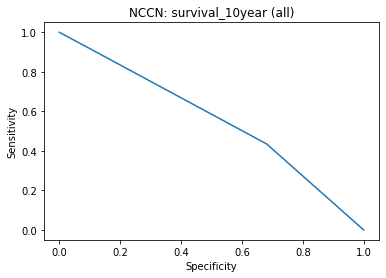

AUC=0.558
Best balanced accuracy: 0.558

------------
RTOG 9202
prob=0.32999999999999996 : n_counts=91
prob=0.33999999999999997 : n_counts=223
prob=0.35 : n_counts=1206
y_vals=0 : n_counts=825
y_vals=1 : n_counts=695


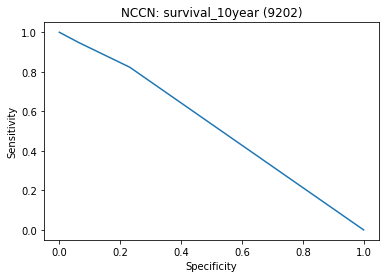

AUC=0.527
Best balanced accuracy: 0.527

------------
RTOG 9408
prob=0.32999999999999996 : n_counts=815
prob=0.33999999999999997 : n_counts=979
prob=0.35 : n_counts=180
y_vals=0 : n_counts=1228
y_vals=1 : n_counts=746


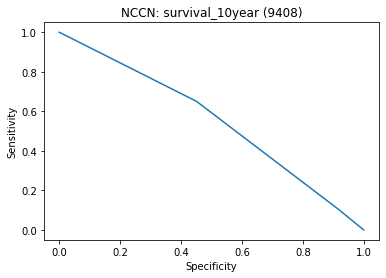

AUC=0.552
Best balanced accuracy: 0.551

------------
RTOG 9413
prob=0.32999999999999996 : n_counts=28
prob=0.33999999999999997 : n_counts=187
prob=0.35 : n_counts=1055
y_vals=0 : n_counts=686
y_vals=1 : n_counts=584


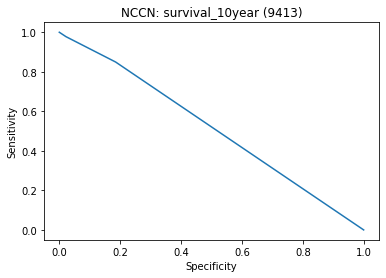

AUC=0.517
Best balanced accuracy: 0.517

------------
RTOG 9910
prob=0.32999999999999996 : n_counts=9
prob=0.33999999999999997 : n_counts=1111
prob=0.35 : n_counts=369
y_vals=0 : n_counts=1064
y_vals=1 : n_counts=425


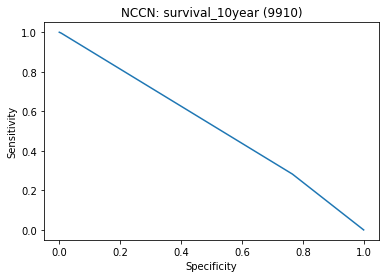

AUC=0.525
Best balanced accuracy: 0.524

------------
RTOG 126
prob=0.33999999999999997 : n_counts=1499
y_vals=0 : n_counts=1039
y_vals=1 : n_counts=460


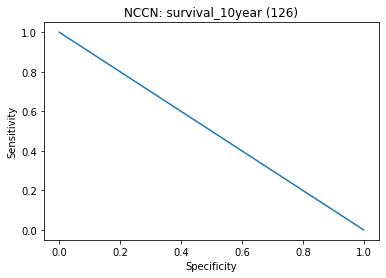

AUC=0.500
Best balanced accuracy: 0.500

------------


In [32]:
def print_val_count(probs, prefix="prob"):
    list(map(lambda pn: print("{}={} : n_counts={}".format(prefix, pn[0],pn[1])), zip(*np.unique(probs, return_counts=True))))

    
nccn_model = NCCN()
    

probs = nccn_model.predict_proba(df_X, outcome=y_var)
print_val_count(probs)
print_val_count(df_y[y_var].values, prefix="y_vals")
plot_ss_curve(df_y[y_var].values, 
              nccn_model.predict_proba(df_X, outcome=y_var), 
              title="NCCN: {} (all)".format(y_var))
print('\n------------')

for sn in df_X_full['sn'].unique():
    print("RTOG {}".format(sn))
    nccn_model = NCCN()
    x = df_X[df_X_full['sn'] == sn].copy()
    y = df_y[df_X_full['sn'] == sn].copy()
    probs = nccn_model.predict_proba(x, outcome=y_var)
    print_val_count(probs)
    print_val_count(y[y_var].values, prefix="y_vals")
    plot_ss_curve(y[y_var].values, probs, title="NCCN: {} ({})".format(y_var, sn))
    print('\n------------')
    


### Performance Comparison: Pathology vs Clinical

Before: X_train (6201, 157)
Before: y_train (6201, 1), pos = [339]
Before: X_test (1551, 157)
Before: y_test (1551, 1), pos = [94]
After: X_train (1596, 128)
After: y_train (1596, 1), pos = [118]
After: X_test (398, 128)
After: y_test (398, 1), pos = [28]
Making Catboost: params_hsearch_image


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

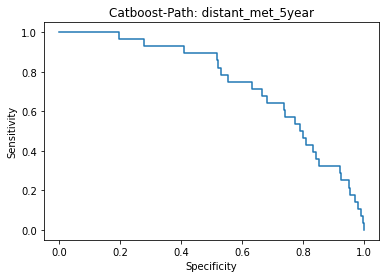

AUC=0.745
Best balanced accuracy: 0.706
Making Catboost: params_hsearch_image


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

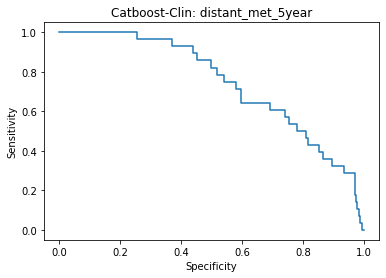

AUC=0.744
Best balanced accuracy: 0.685
Making Catboost: params_hsearch_5yrdm_path_clin


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

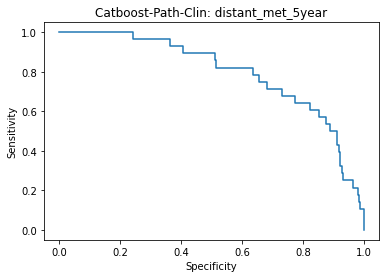

AUC=0.798
Best balanced accuracy: 0.734
Making Catboost: params_hsearch_5yrdm_path_nccn


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

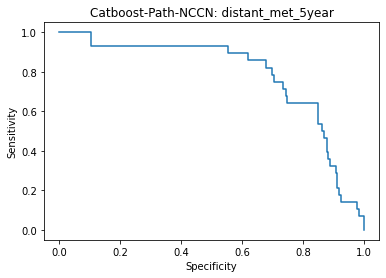

AUC=0.788
Best balanced accuracy: 0.768


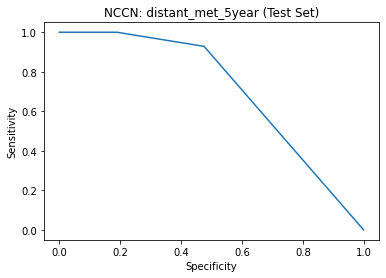

AUC=0.709
Best balanced accuracy: 0.702


In [10]:
from experimental_utils import make_catboost

from clin_utils import filter_for_columns_of_image_features, filter_for_columns_of_image_features_and_nccn_vars
from clin_utils import filter_out_columns_of_image_features
from clin_utils import filter_for_rows_with_image_data

print("Before: X_train {}".format(X_train.shape))
print("Before: y_train {}, pos = {}".format(y_train.shape, sum(y_train.values)))
print("Before: X_test {}".format(X_test.shape))
print("Before: y_test {}, pos = {}".format(y_test.shape, sum(y_test.values)))

x_tr, y_tr = filter_for_rows_with_image_data(X_train, y_train)
x_te, y_te = filter_for_rows_with_image_data(X_test, y_test)

x_te_nccn = x_te.copy()

x_tr_path = filter_for_columns_of_image_features(x_tr)
x_te_path = filter_for_columns_of_image_features(x_te)

x_tr_path_nccn, categorical_nccn = filter_for_columns_of_image_features_and_nccn_vars(x_tr)
x_te_path_nccn, _ = filter_for_columns_of_image_features_and_nccn_vars(x_te)

x_tr_clin = filter_out_columns_of_image_features(x_tr)
x_te_clin = filter_out_columns_of_image_features(x_te)

print("After: X_train {}".format(x_tr_path.shape))
print("After: y_train {}, pos = {}".format(y_tr.shape, sum(y_tr.values)))
print("After: X_test {}".format(x_te_path.shape))
print("After: y_test {}, pos = {}".format(y_te.shape, sum(y_te.values)))

model = make_catboost('params_hsearch_image')
model.fit(x_tr_path, 
          y_tr, 
#           cat_features=categorical, 
          eval_set=(x_te_path, y_te),
          plot=True
         )
plot_ss_curve(y_te, model.predict_proba(x_te_path)[:,1], title="Catboost-Path: {}".format(y_var))

model = make_catboost('params_hsearch_image')
model.fit(x_tr_clin, 
          y_tr, 
#           cat_features=categorical, 
          eval_set=(x_te_clin, y_te),
          plot=True
         )
plot_ss_curve(y_te, model.predict_proba(x_te_clin)[:,1], title="Catboost-Clin: {}".format(y_var))

model = make_catboost('params_hsearch_5yrdm_path_clin')
model.fit(x_tr, 
          y_tr, 
          cat_features=categorical, 
          eval_set=(x_te, y_te),
          plot=True
         )
plot_ss_curve(y_te, model.predict_proba(x_te)[:,1], title="Catboost-Path-Clin: {}".format(y_var))

model = make_catboost('params_hsearch_5yrdm_path_nccn')
model.fit(x_tr_path_nccn, 
          y_tr, 
          cat_features=categorical_nccn, 
          eval_set=(x_te_path_nccn, y_te),
          plot=True
         )
plot_ss_curve(y_te, model.predict_proba(x_te_path_nccn)[:,1], title="Catboost-Path-NCCN: {}".format(y_var))


plot_ss_curve(y_te[y_var].values, 
              nccn_model.predict_proba(x_te_nccn), 
              title="NCCN: {} (Test Set)".format(y_var))

In [72]:
x_tr_path_nccn, categorical_nccn = filter_for_columns_of_image_features_and_nccn_vars(x_tr)
x_te_path_nccn, _ = filter_for_columns_of_image_features_and_nccn_vars(x_te)

model = make_catboost('params_clinimage2')
model.fit(x_tr_path_nccn, 
          y_tr, 
          cat_features=categorical_nccn, 
          eval_set=(x_te_path_nccn, y_te),
          plot=True
         )

Dropping columns ['zubrod', 'kps', 'intercurrent_diabetes', 'ethnicity', 'rx', 'nstage', 'intercurrent_other', 'prior_chemo', 'prior_rt', 'prior_surgery_years', 'prior_surgery', 'rt_complete', 'mstage', 'intercurrent_hypertension', 'race', 'prior_rt_years', 'pelvic_rt', 'node_risk', 'intercurrent_cardio', 'prior_chemo_years', 'prior_cancer', 'prior_hormones', 'age', 'prior_hormone_years']
Dropping columns ['zubrod', 'kps', 'intercurrent_diabetes', 'ethnicity', 'rx', 'nstage', 'intercurrent_other', 'prior_chemo', 'prior_rt', 'prior_surgery_years', 'prior_surgery', 'rt_complete', 'mstage', 'intercurrent_hypertension', 'race', 'prior_rt_years', 'pelvic_rt', 'node_risk', 'intercurrent_cardio', 'prior_chemo_years', 'prior_cancer', 'prior_hormones', 'age', 'prior_hormone_years']
Making Catboost: params_clinimage2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### TabNet

In [42]:
from sklearn.preprocessing import LabelEncoder

def TabNetFormat(df, categorical_names):
    """Fills numerical nans with the column mean, and label-encodes categorical variables"""
    df_tn = df.copy()
    for col in df_tn.columns:
        if col not in categorical_names:
            df_tn[col].fillna(df_tn[col].mean(), inplace=True)
        else:
            l_enc = LabelEncoder()
            df_tn[col] = df_tn[col].fillna('nan')
            df_tn[col] = l_enc.fit_transform(df_tn[col].values)
    df_tn.fillna(0, inplace=True)
    return df_tn

X_train_tn = TabNetFormat(X_train, categorical_names)
X_test_tn = TabNetFormat(X_test, categorical_names)

In [45]:
drops = [col for col in X_train_tn.columns if len(col) <= 4 and col[0] == 'f']
X_train_tn.drop(columns=drops, inplace=True)
X_test_tn.drop(columns=drops, inplace=True)

In [192]:
import torch
from pytorch_tabnet.pretraining import TabNetPretrainer

cat_idxs = np.array(list(categorical))
cat_dims = np.array(list(categorical_dims.values()))
cat_emb_dims = list(map(int, np.round(1.6 * cat_dims ** 0.56)))

unsupervised_model = TabNetPretrainer(
    cat_idxs=list(cat_idxs),
    cat_dims=list(cat_dims),
    cat_emb_dim=cat_emb_dims,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3), # Searched to get to this lr
    mask_type='entmax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=X_train_tn.values.copy(),
    eval_set=[X_test_tn.values.copy()],
    pretraining_ratio=0.4,
)

In [24]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

clf = TabNetClassifier(
    cat_idxs=list(categorical),
    cat_dims=list(categorical_dims.values()),
    cat_emb_dim=4, #TODO: should this be a list of the cardinality of each categorical class? For one-hot embeddings.
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
#     scheduler_params={"step_size":10,
#                      "gamma":0.90},
#     scheduler_fn=torch.optim.lr_scheduler.StepLR,
#     optimizer_fn=torch.optim.Adam,
#     optimizer_params=dict(lr=1e-3), # Searched to get to this lr
#     scheduler_params={"step_size":50, # how to use learning rate scheduler
#                      "gamma":0.9},
#     scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax' # "sparsemax"
)
clf.fit(
    X_train_tn.values,
    y_train_p.values.reshape((-1,)), 
    eval_set=[(X_train_tn.values, y_train_p.values.reshape((-1,))),
              (X_test_tn.values, y_test.values.reshape((-1,)))
             ],
    eval_name = ['train', 'test'],
#     eval_metric=['auc'],
    from_unsupervised=unsupervised_model,
#     patience=0,
)

Device used : cpu
Loading weights from unsupervised pretraining


Pretraining: cat_emb_dim changed from 4 to [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3]
Pretraining: cat_idxs changed from [2, 6, 7, 8, 9, 12, 14, 15, 16, 19, 20, 22, 24, 25, 26] to []


epoch 0  | loss: 0.49399 | train_auc: 0.39966 | test_auc: 0.51757 |  0:00:01s
epoch 1  | loss: 0.26873 | train_auc: 0.50528 | test_auc: 0.57552 |  0:00:02s
epoch 2  | loss: 0.2441  | train_auc: 0.61124 | test_auc: 0.59959 |  0:00:03s
epoch 3  | loss: 0.23067 | train_auc: 0.61329 | test_auc: 0.61543 |  0:00:04s
epoch 4  | loss: 0.21926 | train_auc: 0.60392 | test_auc: 0.66065 |  0:00:06s
epoch 5  | loss: 0.21876 | train_auc: 0.60708 | test_auc: 0.66419 |  0:00:07s
epoch 6  | loss: 0.21395 | train_auc: 0.61001 | test_auc: 0.6845  |  0:00:08s
epoch 7  | loss: 0.21172 | train_auc: 0.62562 | test_auc: 0.67862 |  0:00:09s
epoch 8  | loss: 0.21111 | train_auc: 0.63343 | test_auc: 0.6747  |  0:00:10s
epoch 9  | loss: 0.208   | train_auc: 0.64799 | test_auc: 0.66934 |  0:00:11s
epoch 10 | loss: 0.21021 | train_auc: 0.65392 | test_auc: 0.66477 |  0:00:13s
epoch 11 | loss: 0.20781 | train_auc: 0.67036 | test_auc: 0.67679 |  0:00:14s
epoch 12 | loss: 0.20715 | train_auc: 0.6584  | test_auc: 0.6851

### Experimentation

In [183]:
params = {
    'iterations':150,
    'learning_rate':0.1,
    'depth':2,
    'verbose':False,
    'thread_count':4,
    'one_hot_max_size':10, # Our data's categorical features have max of 6
    'train_dir' : '/tmp/catboost_info',
    'eval_metric':'AUC',
}
params_2 = {
    'iterations':150,
    'learning_rate':0.1,
    'depth':2,
    'verbose':False,
    'thread_count':4,
    'one_hot_max_size':10, # Our data's categorical features have max of 6
    'train_dir' : '/tmp/catboost_info',
    'eval_metric':'AUC',
}
# From a hypeopt on 2/17
best_params = {
    'depth': 3, 
    'l2_leaf_reg': 4.0, 
    'learning_rate': 0.2135814429272365, 
    'iterations':500,
    'verbose':False,
    'thread_count':4,
    'eval_metric':'AUC',
    'early_stopping_rounds':300,
    'train_dir' : '/tmp/catboost_info',
}

#WHENCE: THIS IMPROVES ON THE ABOVE!!! 0.745 original AUC
best_params = {
    'depth': 12, #3,6: >0.74
    #     'depth': 9, #3,6: >0.74
    'l2_leaf_reg': 4.0, 
#     'learning_rate': 0.007, #this, with depth 14, hits 0.766
#     'learning_rate': 0.009, #this, with depth 12, hits 0.768 (l2-leaf-reg = 4)
#     'learning_rate': 0.009, #this, with depth 13, hits 0.766
    'learning_rate': 0.007, #this, with depth 12, hits 0.763
#     'learning_rate': 0.009, #this, with depth 12, hits 0.768
#     'learning_rate': 0.010, #this, with depth 12, hits 0.7688
#     'learning_rate': 0.011, #this, with depth 12, hits 0.768
#     'learning_rate': 0.011, #this, with depth 11, hits 0.768
#     'learning_rate': 0.015195256881331766, #this, with depth 9, hits 0.76
#     'learning_rate': 0.035195256881331766,
#     'learning_rate': 0.075195256881331766,
    'eval_metric':'AUC',
    'early_stopping_rounds':300,
    'train_dir' : '/tmp/catboost_info',
    'verbose':False,
    'thread_count':64,
    'iterations':2000,
    'task_type':"CPU",
}

model = CatBoostClassifier(**best_params)
# model = CatBoostClassifier(**best_params)
model.fit(X_train, y_train, 
          cat_features=categorical,
          eval_set=(X_test, y_test),
          plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [179]:
p = model.get_params()
p['learning_rate'] = 0.007
model2 = CatBoostClassifier(**p)
model2.fit(X_train, y_train, 
          cat_features=categorical,
          eval_set=(X_test, y_test),
          plot=True,
          init_model=model,
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Cross Validation

In [113]:
from catboost import CatBoostClassifier, Pool, cv

cv_params = model.get_params()
cv_params.update({
    'loss_function': 'Logloss',
})
cv_data = cv(
    Pool(X_train, y_train, cat_features=categorical),
    cv_params,
    fold_count=10,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### HyperOptimization

In [108]:
import hyperopt
from catboost import CatBoostClassifier, Pool, cv

def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        depth=params['depth'],
        iterations=500,
        eval_metric='AUC',
        random_seed=42,
        verbose=False,
        loss_function='Logloss',
        early_stopping_rounds=300,
        train_dir='/tmp/catboost_info',
    )
    
    cv_data = cv(
        Pool(X_train, y_train, cat_features=categorical),
        model.get_params()
    )
    best_accuracy = np.max(cv_data['test-AUC-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [109]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 4, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-6, 5e-1),
    'depth' : hyperopt.hp.choice('depth', [2,4,6,8,10])
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

Stopped by overfitting detector  (300 iterations wait)

Stopped by overfitting detector  (300 iterations wait)                              

Stopped by overfitting detector  (300 iterations wait)                              

Stopped by overfitting detector  (300 iterations wait)                              

Stopped by overfitting detector  (300 iterations wait)                              

Stopped by overfitting detector  (300 iterations wait)                            

Stopped by overfitting detector  (300 iterations wait)                            

Stopped by overfitting detector  (300 iterations wait)                            

Stopped by overfitting detector  (300 iterations wait)                            

Stopped by overfitting detector  (300 iterations wait)                            

Stopped by overfitting detector  (300 iterations wait)                             

Stopped by overfitting detector  (300 iterations wait)                           

Stopped by o

In [112]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    depth=best['depth'],
    iterations=50,
    eval_metric='AUC',
    random_seed=42,
    verbose=False,
    loss_function='Logloss',
)
cv_data = cv(Pool(X_train, y_train, cat_features=categorical), model.get_params(), fold_count=10)

In [113]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-AUC-mean'])))

Precise validation accuracy score: 0.711969482064633


In [114]:
best

{'depth': 3, 'l2_leaf_reg': 44.0, 'learning_rate': 0.18161980939519}

# Decipher

Average GC + SOC score: 0.76


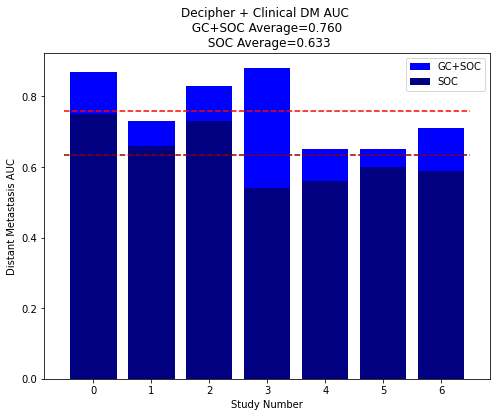

GC+SOC: [0.87 0.73 0.83 0.88 0.65 0.65 0.71]
SOC: [0.75 0.66 0.73 0.54 0.56 0.6  0.59]


In [50]:
soc = np.array([0.75, 0.66, 0.73, 0.54, 0.56, 0.6, 0.59])
gc_plus_soc = np.array([0.87, 0.73, 0.83, 0.88, 0.65, 0.65, 0.71])
m = np.mean(gc_plus_soc)
print("Average GC + SOC score: {}".format(m))

import matplotlib.pyplot as plt

x = range(len(gc_plus_soc))
plt.figure(figsize=(8,6))
plt.bar(x, gc_plus_soc, color='blue', label='GC+SOC')
plt.bar(x, soc, color='navy', label='SOC')
plt.hlines(m, x[0]-0.5, x[-1]+0.5, colors='red', linestyles='dashed')
plt.hlines(np.mean(soc), x[0]-0.5, x[-1]+0.5, colors='darkred', linestyles='dashed')
plt.title("Decipher + Clinical DM AUC \n GC+SOC Average={:.3f} \n SOC Average={:.3f}".format(m, np.mean(soc)))
plt.xlabel("Study Number")
plt.ylabel("Distant Metastasis AUC")
plt.legend()
plt.show()

print("GC+SOC: {}".format(gc_plus_soc))
print("SOC: {}".format(soc))

# Grade Osama

 - https://docs.google.com/spreadsheets/d/12vVQl7nXv4aL8EwrwMr101gHEqzs2w63/edit#gid=691413542


In [19]:
import matplotlib.pyplot as plt
import numpy as np
from rtog_helper import RTOG, sens_spec, plot_ss_curve

In [20]:
rtog_answers = RTOG("./rtog_9202_human_test_answers.csv", study_number='9202', file_type="csv")

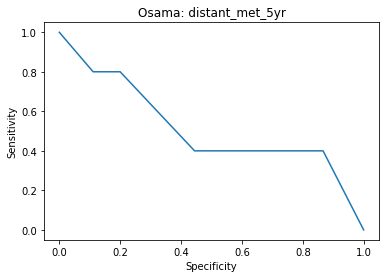

AUC=0.513
Best balanced accuracy: 0.633


In [21]:
# Load Answers: distant_met_5year 
# Force binary: Set 2 to 0. 2 is competing events. 0 is censored.
rtog_answers = RTOG("./rtog_9202_human_test_answers.csv", study_number='9202', file_type="csv")
gt = rtog_answers['distant_met_5year']
gt.df[gt.df == 2] = 0 

# Load Osama
rtog_osama = RTOG("./test_OM.csv", file_type="csv")
probs = rtog_osama.df['5 yr distant_met']

# SS Curve
gt_vec = gt.df.values
probs_vec = probs.values / 100.0
plot_ss_curve(gt_vec, probs_vec, title="Osama: distant_met_5yr")

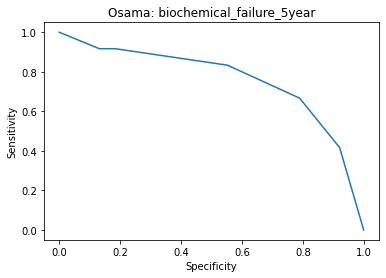

AUC=0.762
Best balanced accuracy: 0.728


In [22]:
# Load Answers: biochemical_failure_5year 
# Force binary: Set 2 to 0. 2 is competing events. 0 is censored.
rtog_answers = RTOG("./rtog_9202_human_test_answers.csv", study_number='9202', file_type="csv")
rtog_answers.add_biochemical_failure_Nyr_endpoint(5)
gt = rtog_answers['biochemical_failure_5year']
gt.df[gt.df == 2] = 0 

# Load Osama
rtog_osama = RTOG("./test_OM.csv", file_type="csv")
probs = rtog_osama.df['5 yr biochemical_failure']

gt_vec = gt.df.values
probs_vec = probs.values / 100.0
plot_ss_curve(gt_vec, probs_vec, title="Osama: biochemical_failure_5year")

In [10]:
from datetime import datetime
import re
re.sub("[. /]", "", str(datetime.now()) + "/ / /g")

'2021-06-2223:34:37114475g'